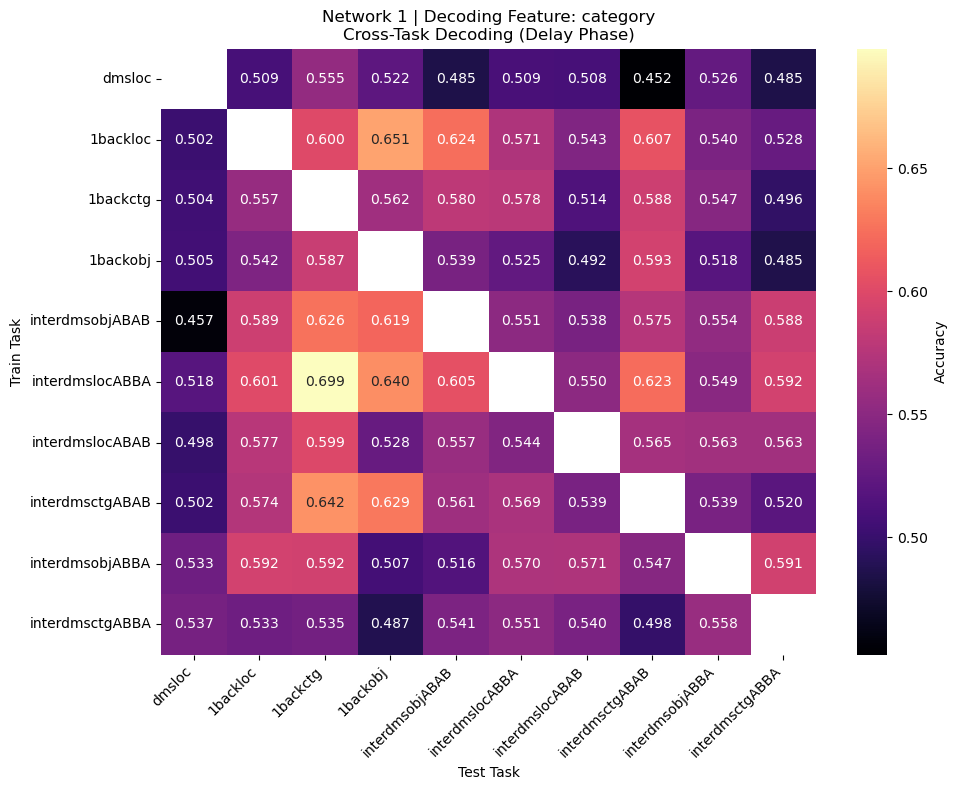

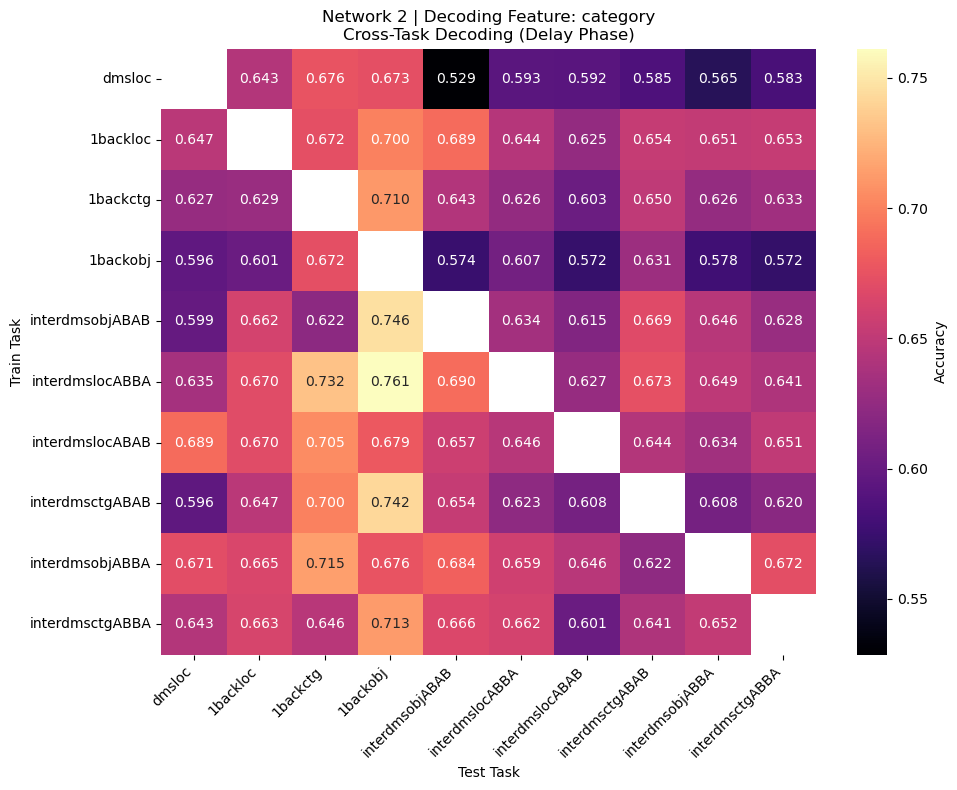

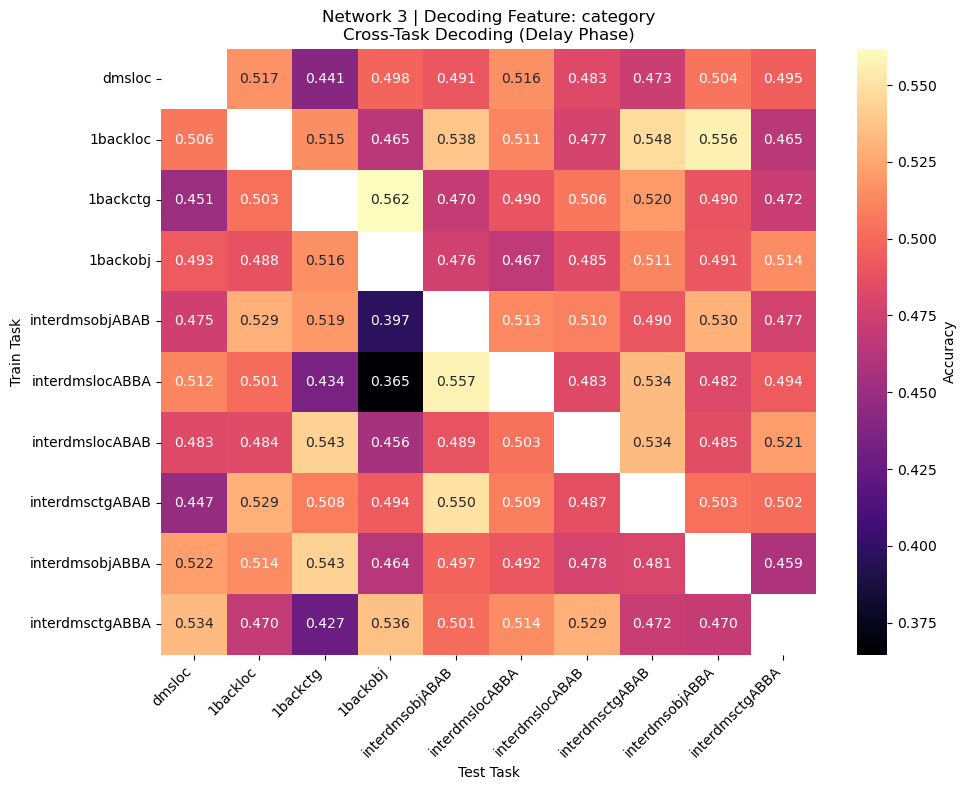

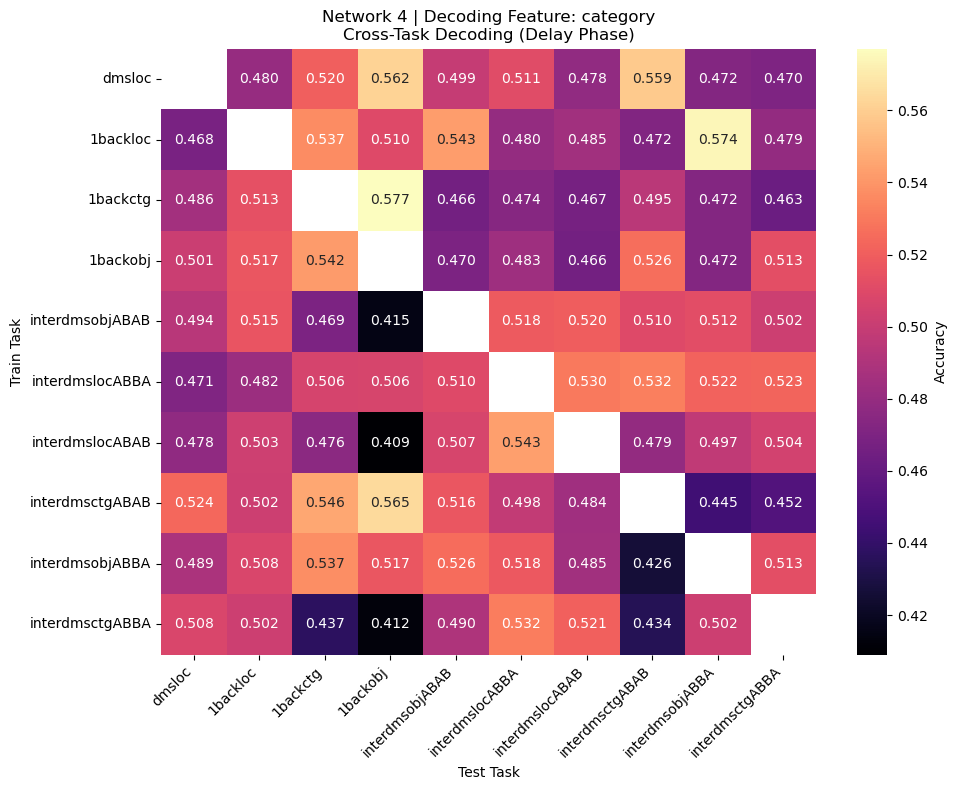

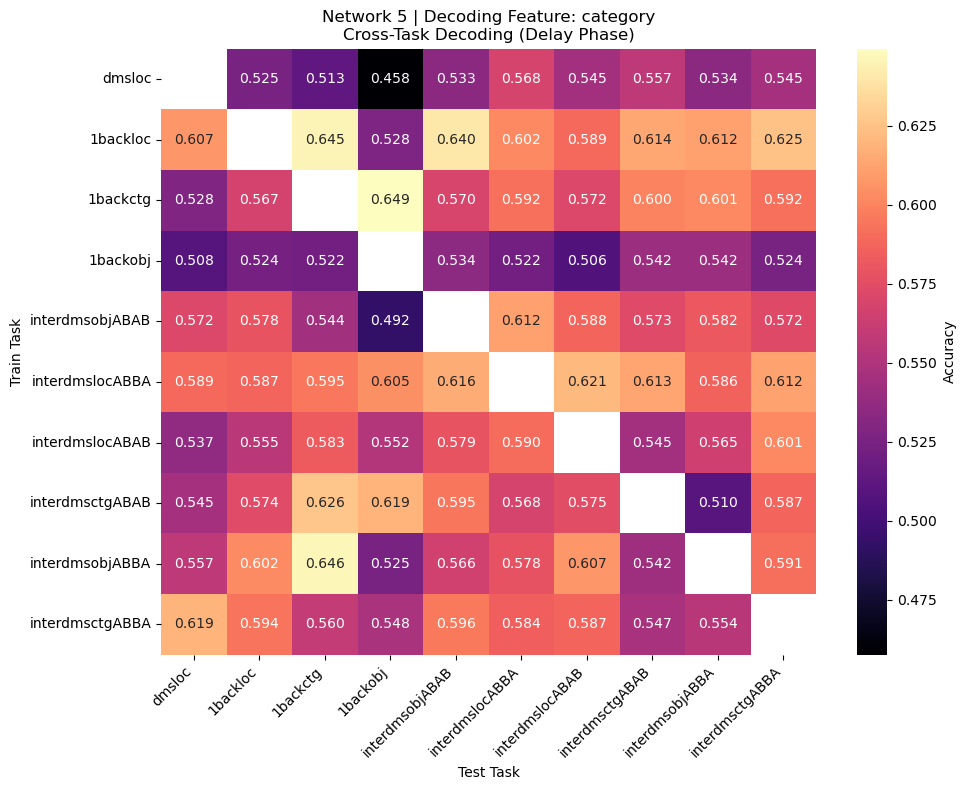

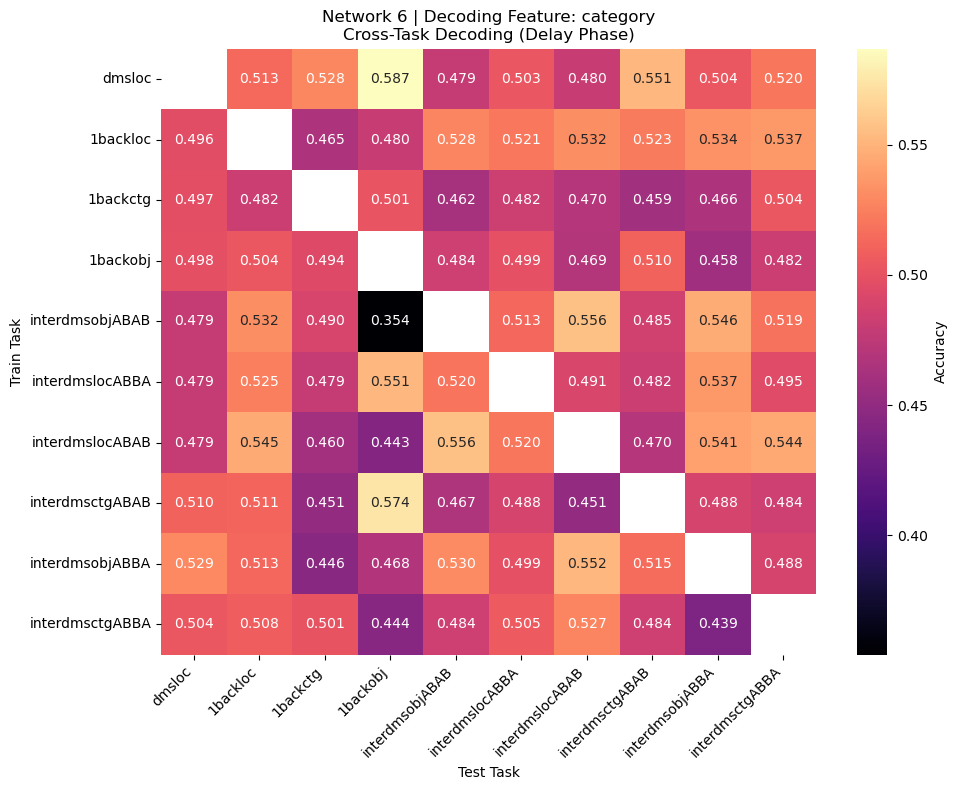

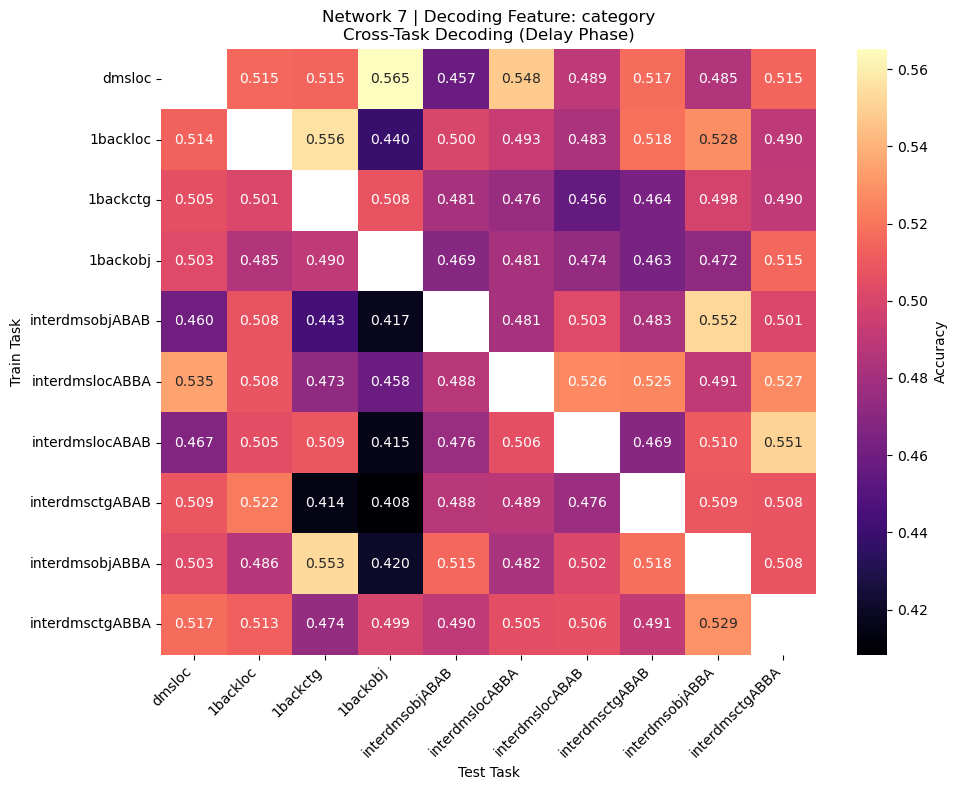

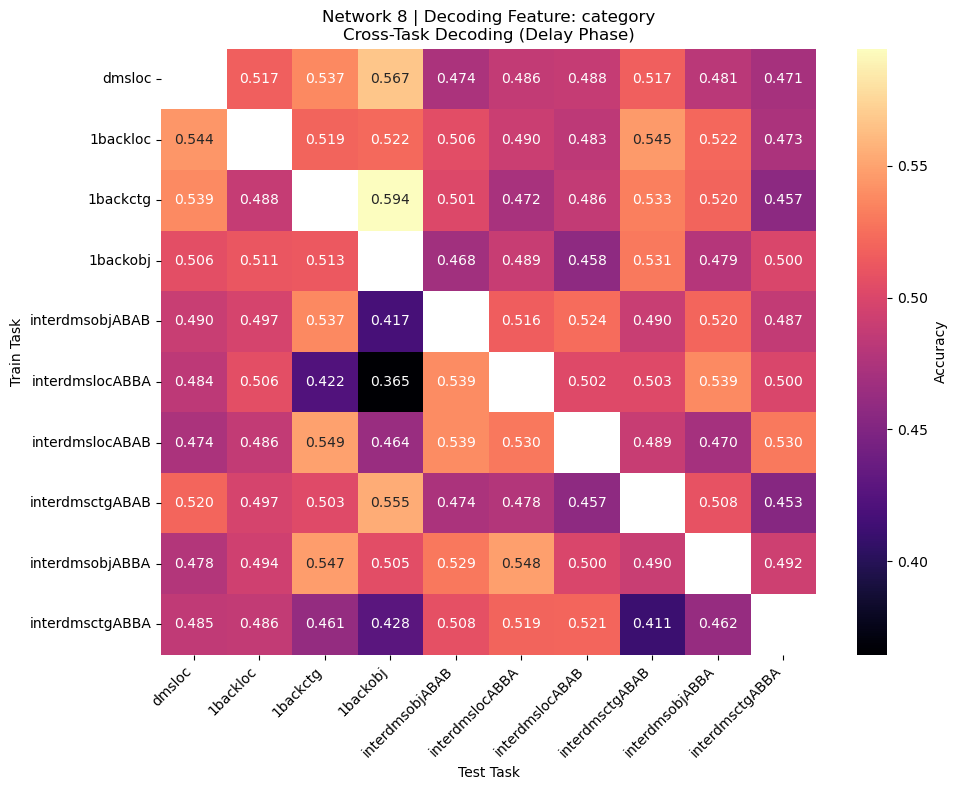

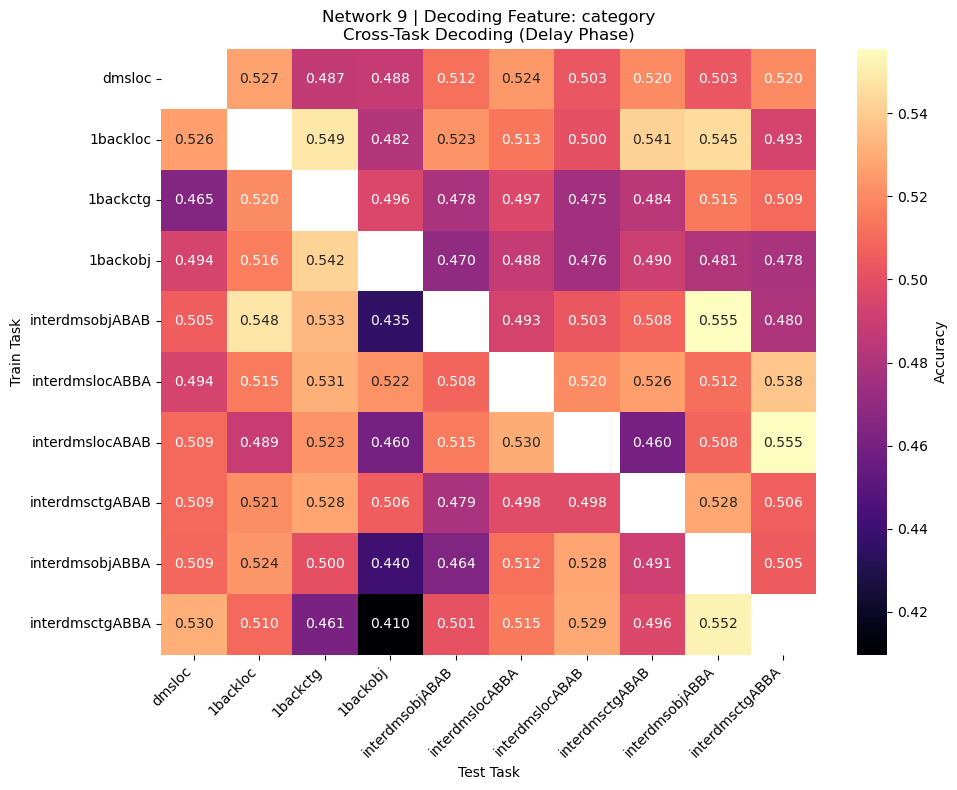

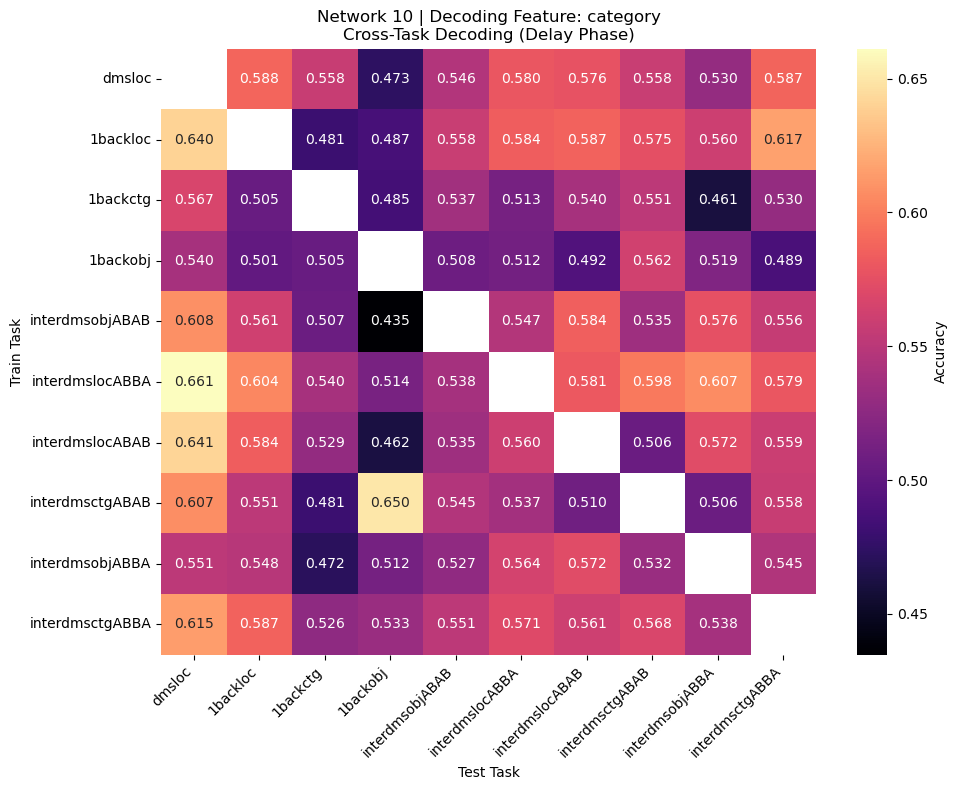

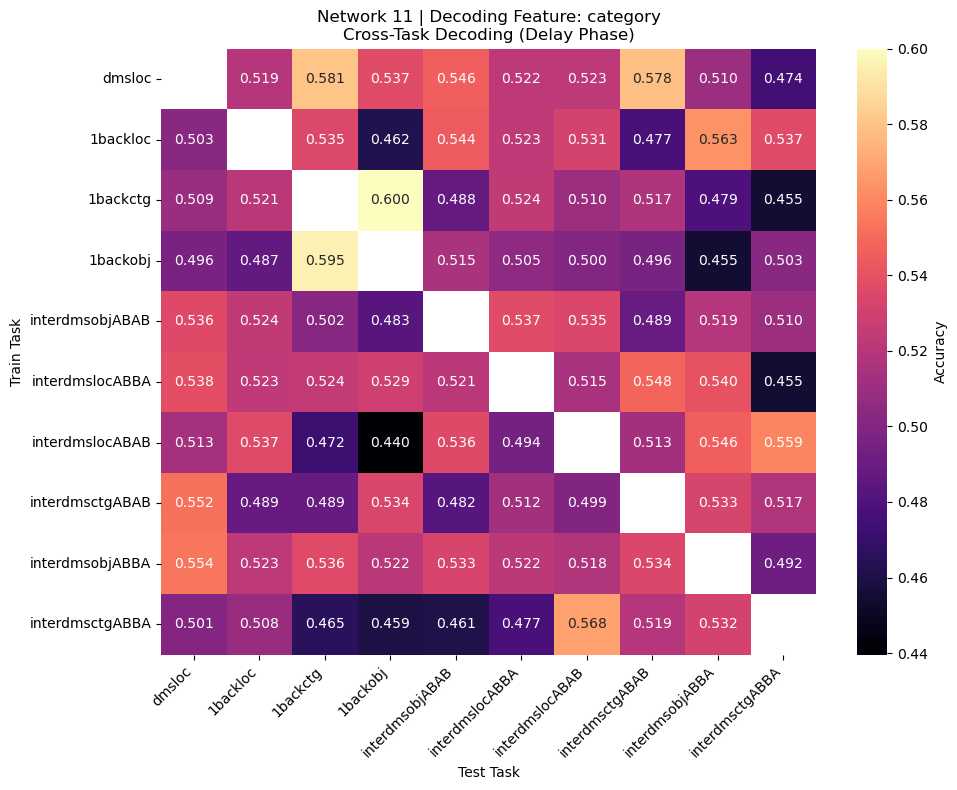

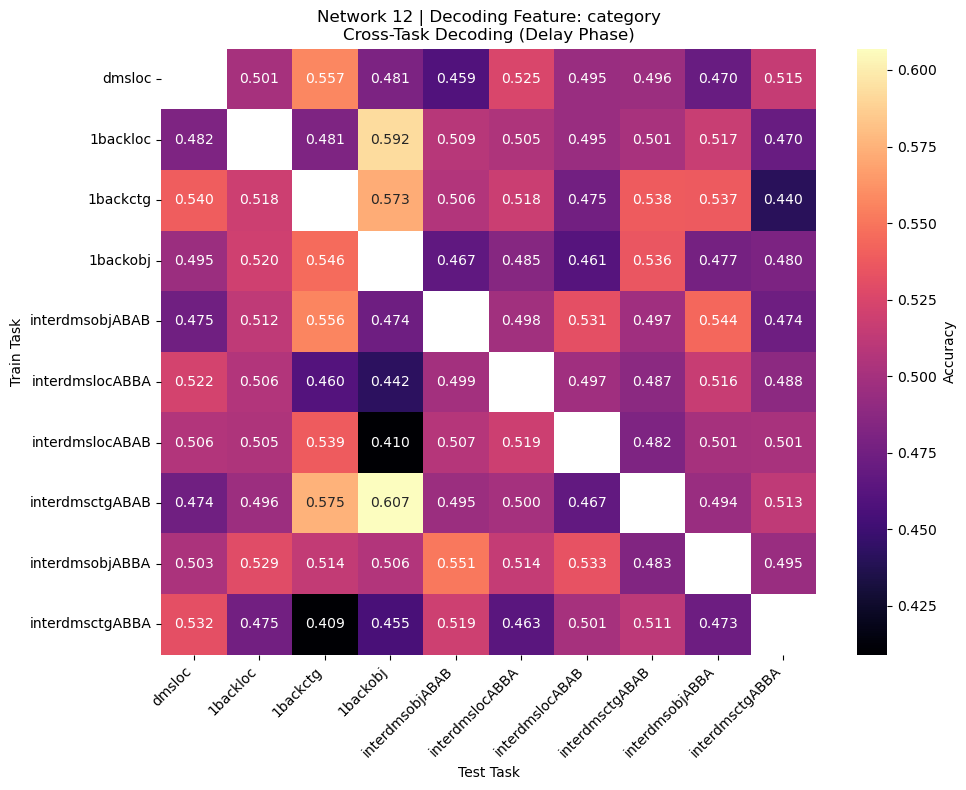

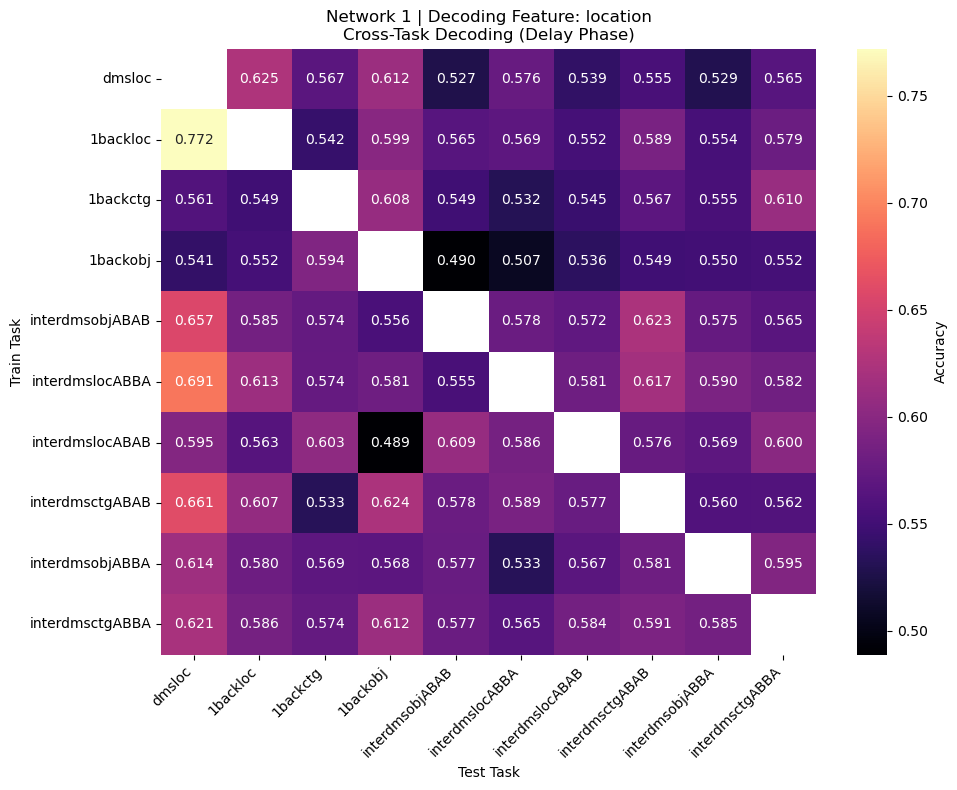

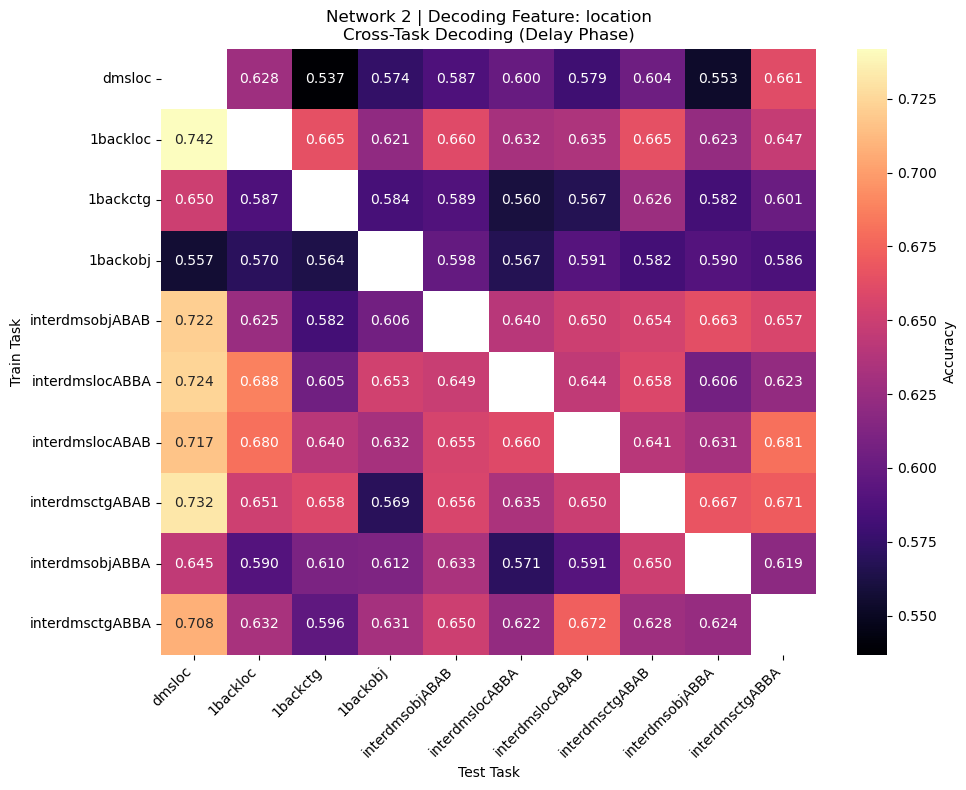

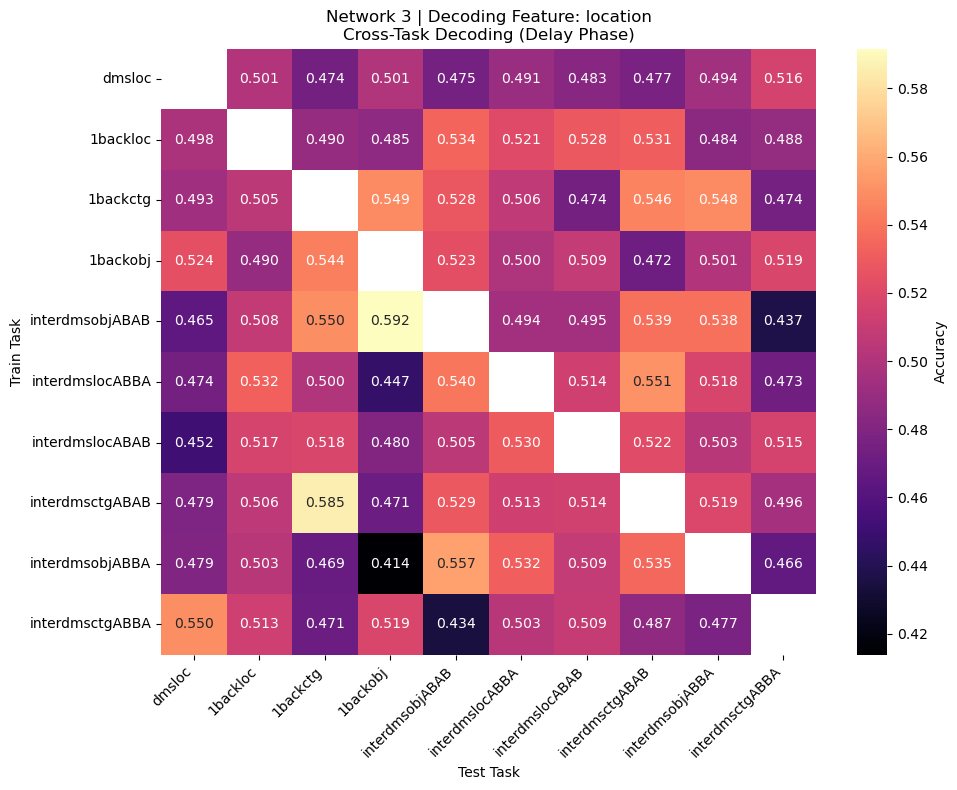

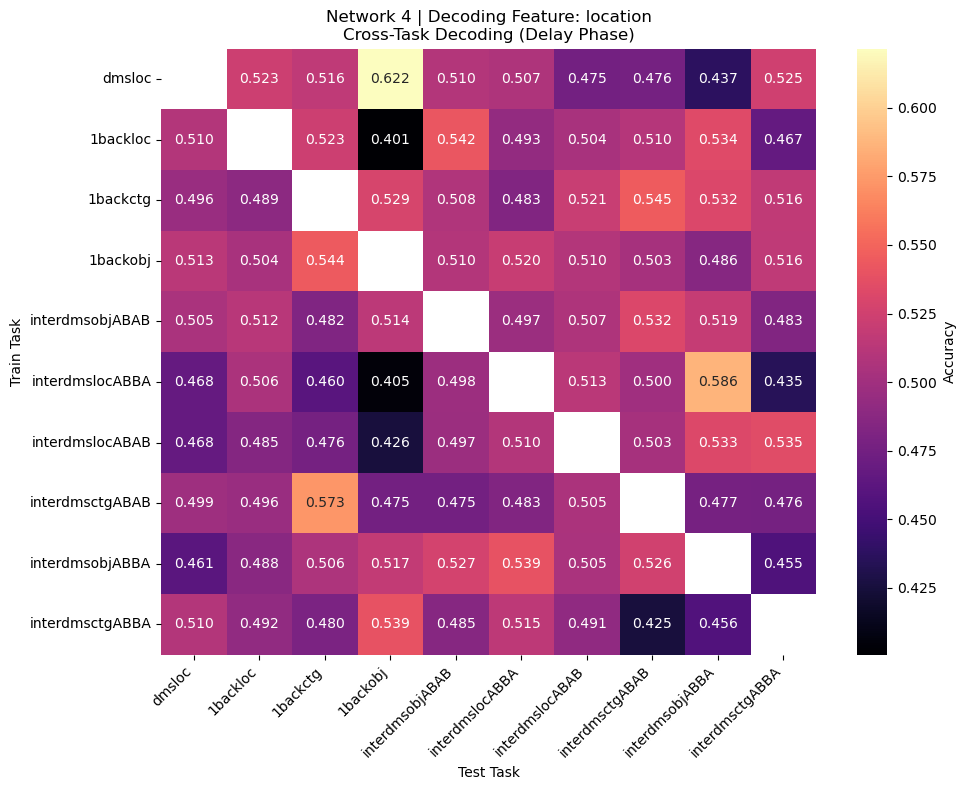

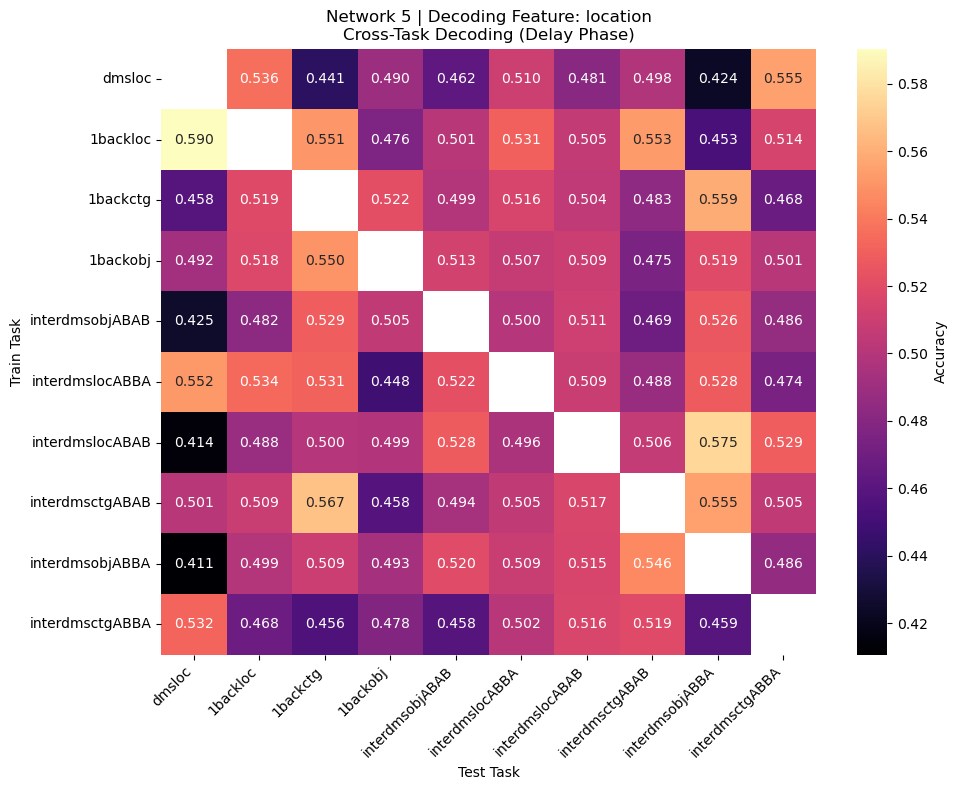

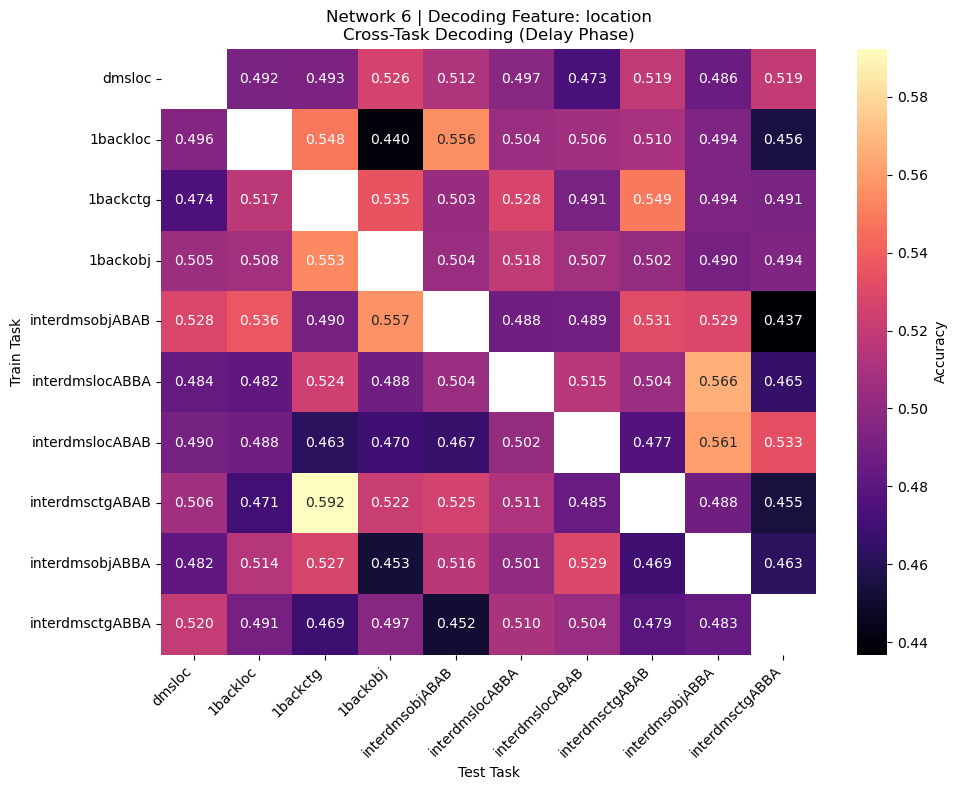

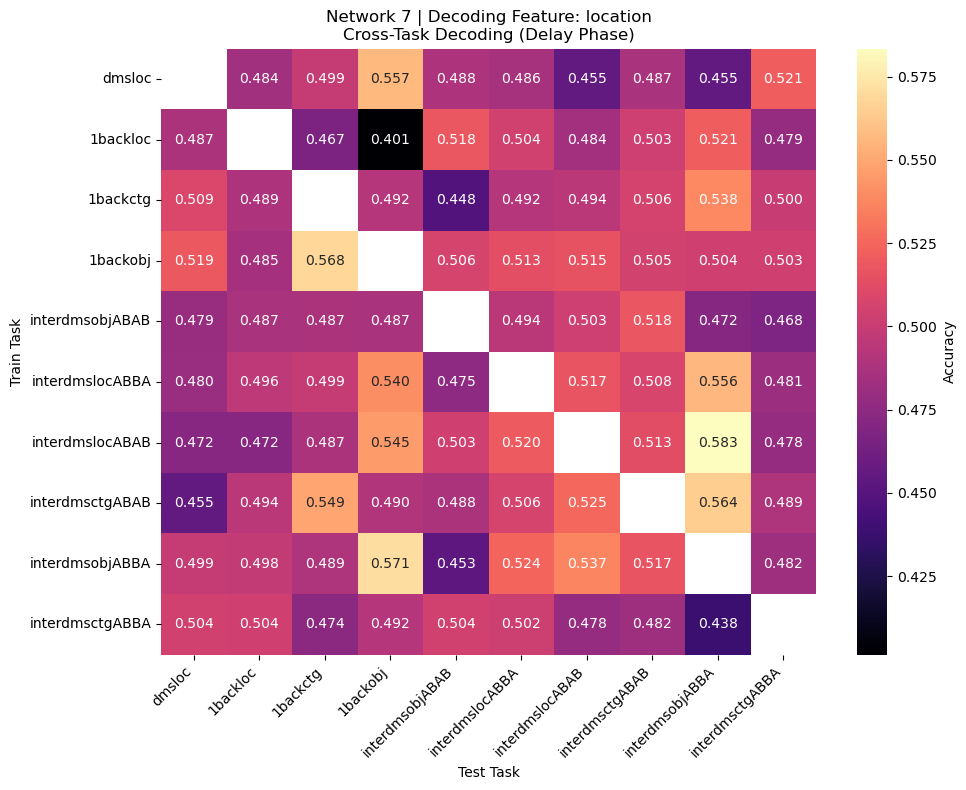

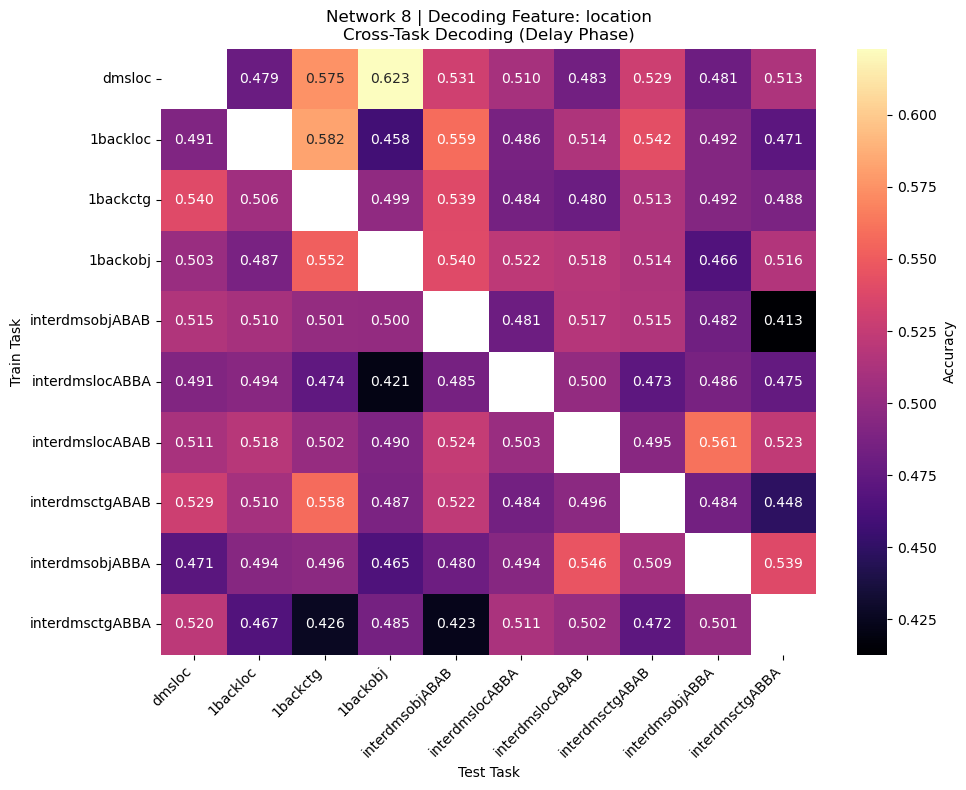

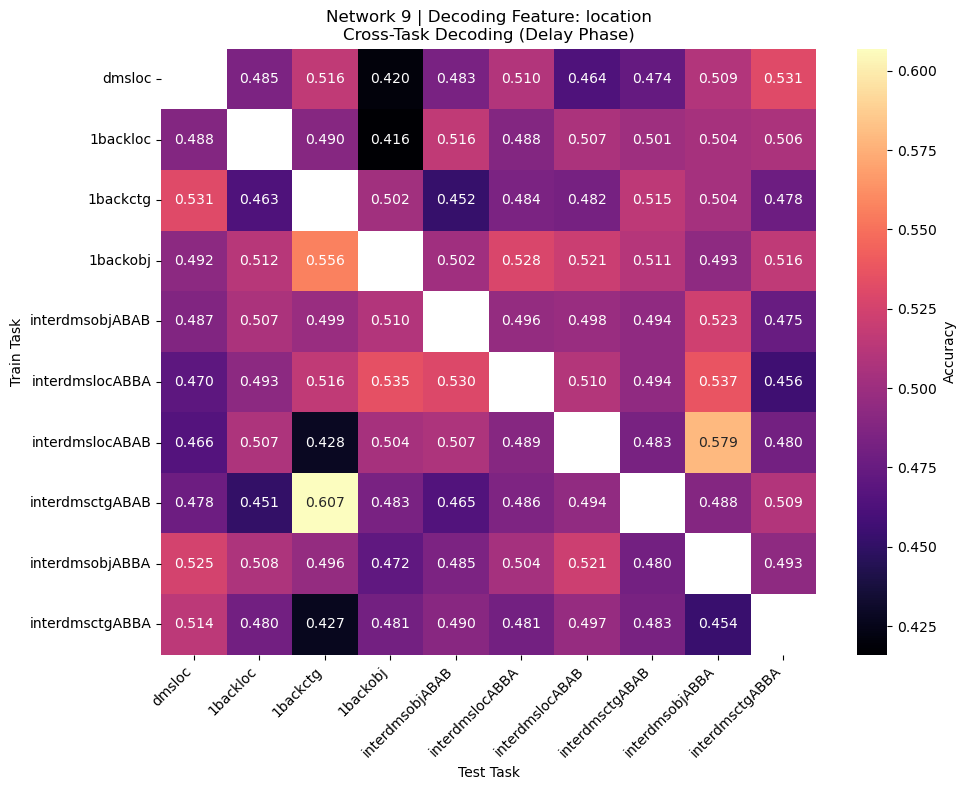

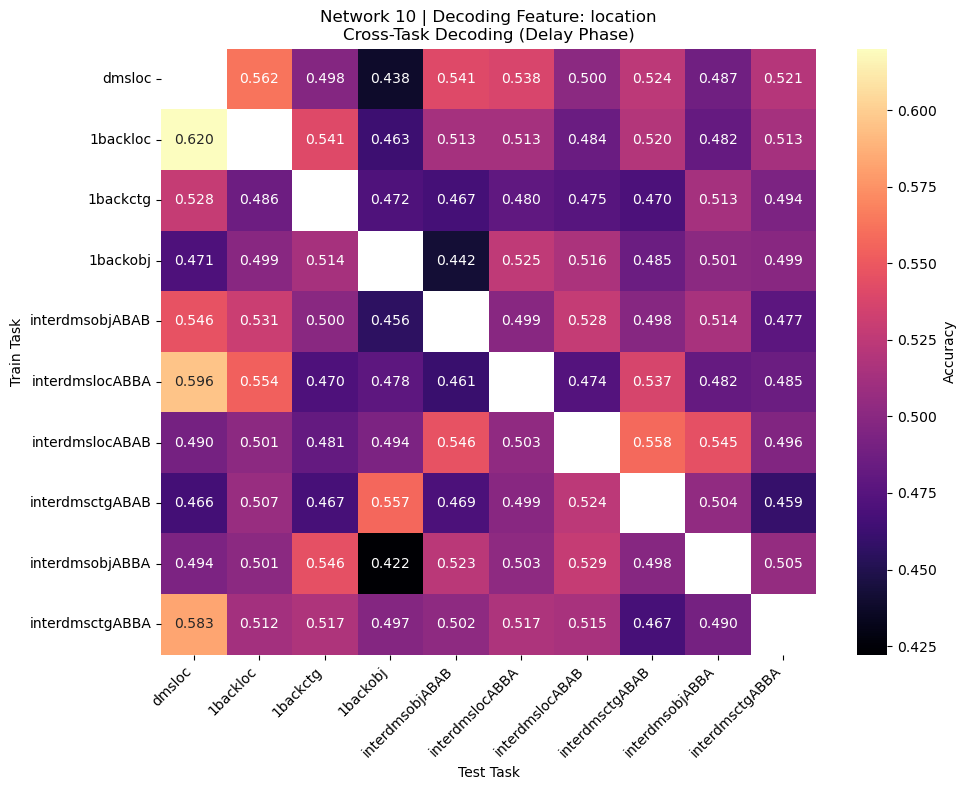

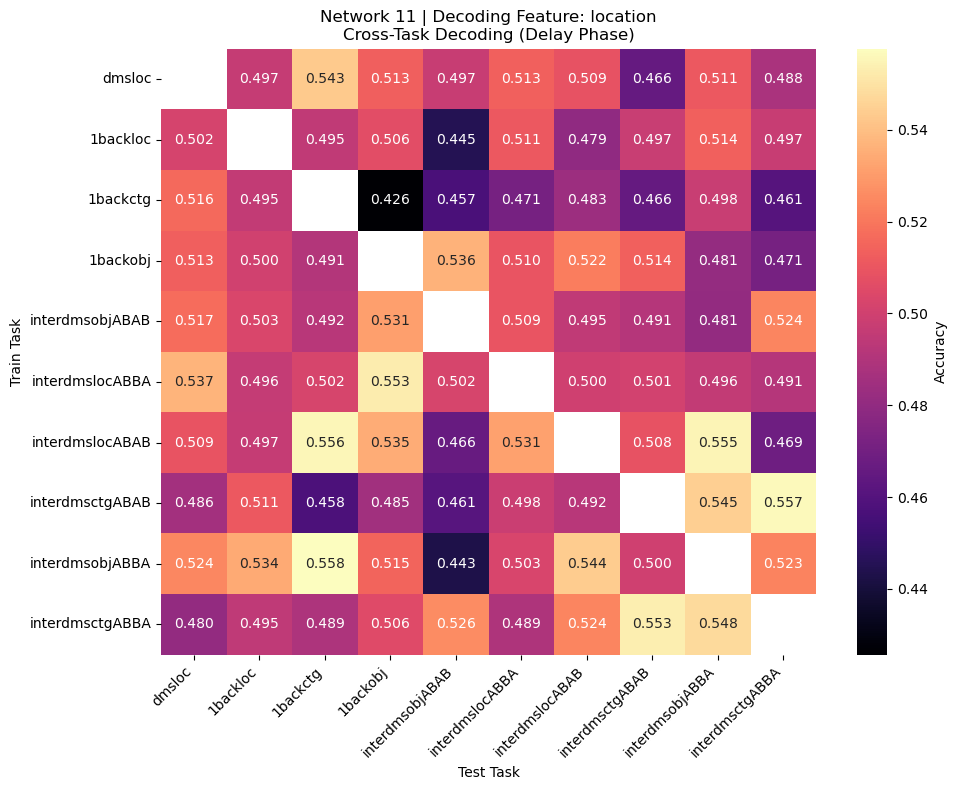

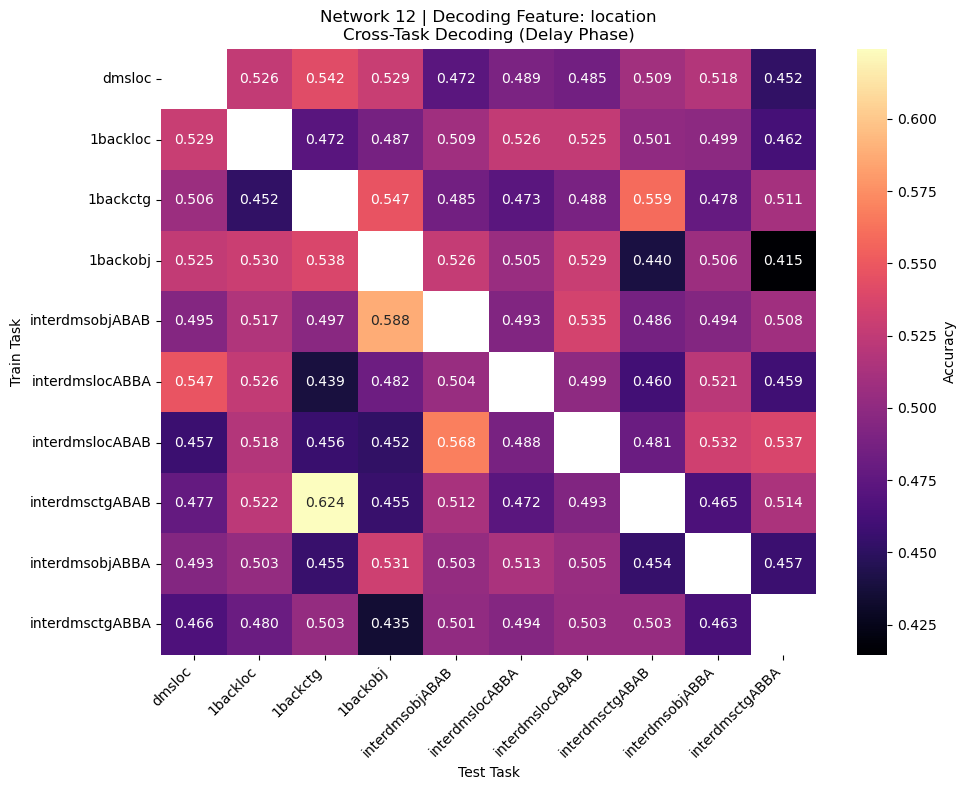

In [3]:
import os
import numpy as np
import nibabel as nib
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# === Config ===
parent_dir = Path("/home/xiaoxuan/projects/202406_fMRI/")  # change this
decoding_features = ["category", "location"]
tasks = ["dmsloc", "1backloc", "1backctg", "1backobj", "interdmsobjABAB",
         "interdmslocABBA", "interdmslocABAB", "interdmsctgABAB", "interdmsobjABBA", "interdmsctgABBA"]
reps = [1, 2, 3, 4, 5]
network_ids = list(range(1, 13))  # Cole-Anticevic networks: 1 to 12

# Load voxel-to-network assignment
glasser_atlas_path = os.path.join(parent_dir, 'data', 'Glasser_LR_Dense64k.dlabel.nii')
glasser_atlas = nib.load(glasser_atlas_path).get_fdata()[0].astype(int)
network_region_assignment = np.loadtxt(os.path.join(parent_dir, 'data', 'cortex_parcel_network_assignments.txt'), dtype=int)

network_voxelwise_assignment = np.zeros((glasser_atlas.shape[0], 1))
for region in range(1, 361):
    region_idx = np.where(glasser_atlas == region)[0]
    network_voxelwise_assignment[region_idx] = network_region_assignment[region - 1]
network_voxelwise_assignment = network_voxelwise_assignment.squeeze()

# === Loop over features and networks ===
for feat in decoding_features:
    for net_id in network_ids:
        acc_matrix = np.full((len(tasks), len(tasks)), np.nan)

        for i, train_task in enumerate(tasks):
            for j, test_task in enumerate(tasks):
                if train_task == test_task:
                    continue  # skip diagonal

                accs = []
                for rep in reps:
                    acc_path = parent_dir / f"network_level_results_cross_task/{train_task}_to_{test_task}_{feat}/regionwise_acc_rep{rep}.npy"
                    if not acc_path.exists():
                        continue

                    acc_map = np.load(acc_path).squeeze()
                    region_idx = np.where(network_voxelwise_assignment == net_id)[0]

                    if len(region_idx) > 0:
                        region_acc = acc_map[region_idx].mean()
                        accs.append(region_acc)

                if accs:
                    acc_matrix[i, j] = np.mean(accs)

        # === Plot heatmap ===
        plt.figure(figsize=(10, 8))
        sns.heatmap(acc_matrix, xticklabels=tasks, yticklabels=tasks, annot=True, fmt=".3f",
                    cmap="magma", mask=np.isnan(acc_matrix), cbar_kws={"label": "Accuracy"})
        plt.title(f"Network {net_id} | Decoding Feature: {feat}\nCross-Task Decoding (Delay Phase)")
        plt.xlabel("Test Task")
        plt.ylabel("Train Task")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()


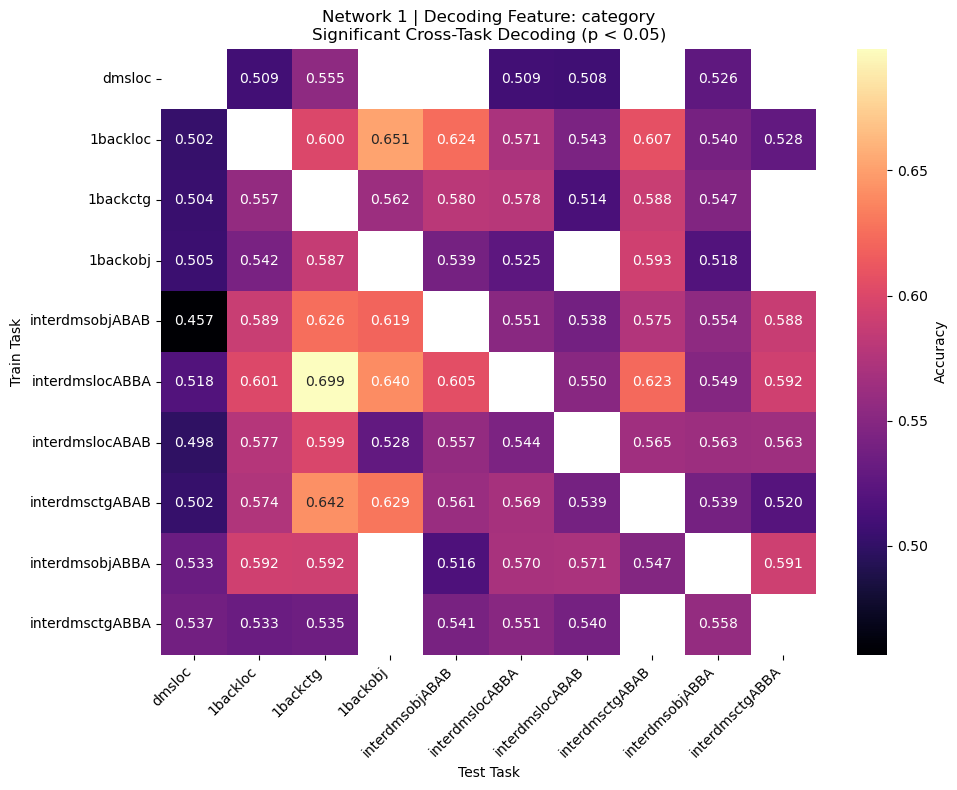

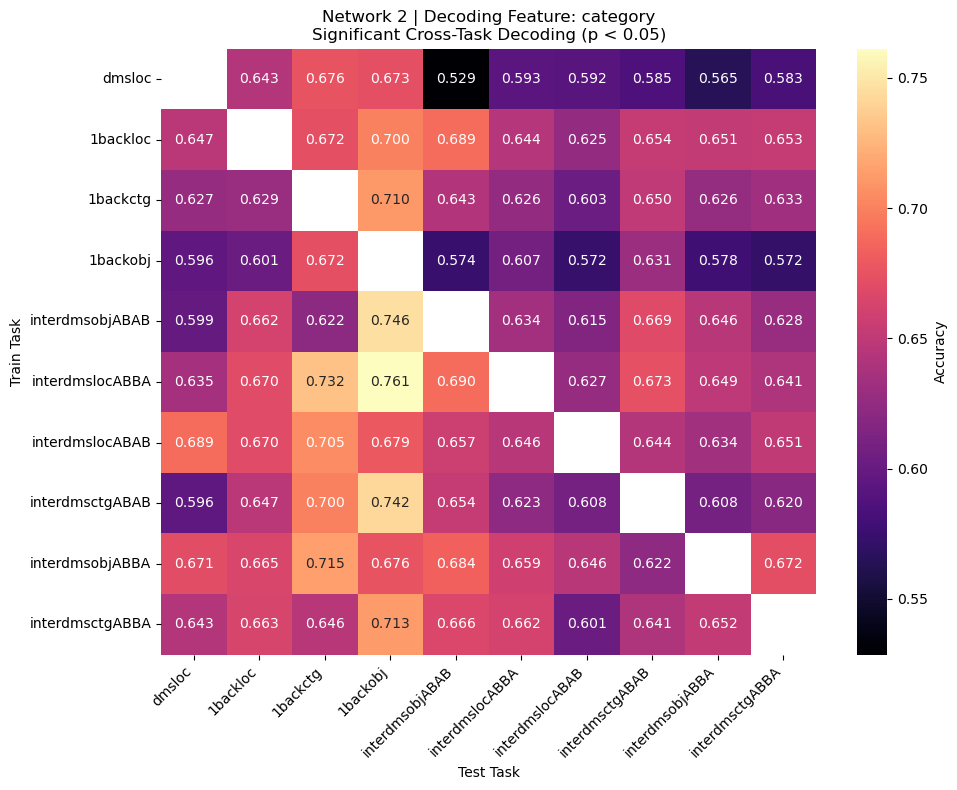

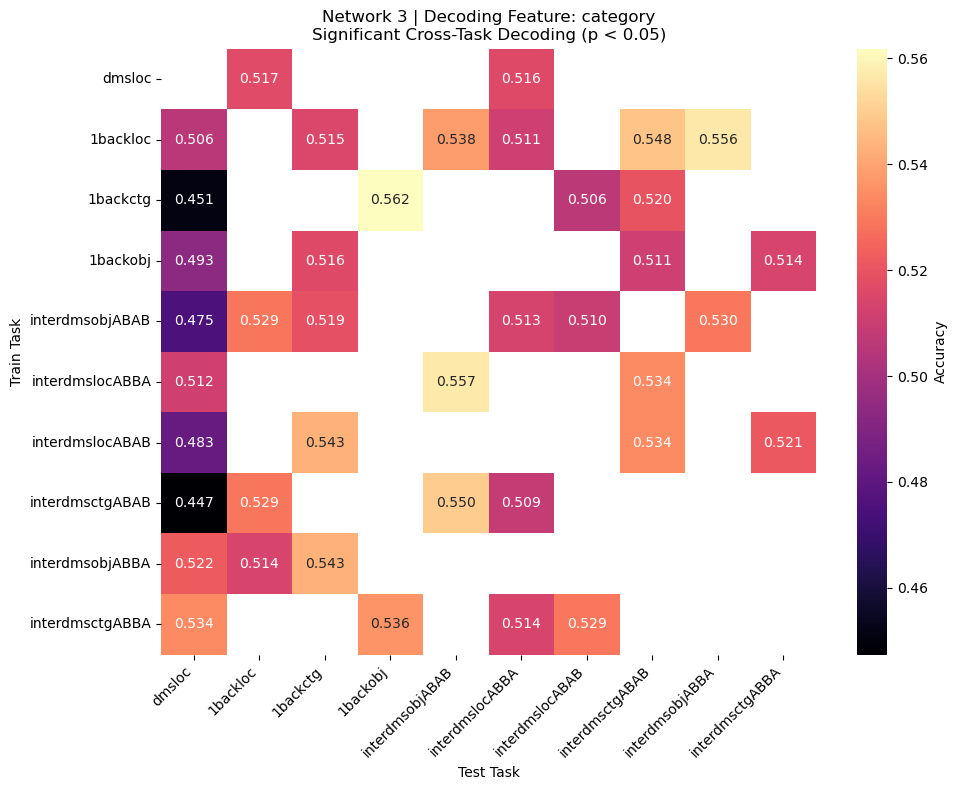

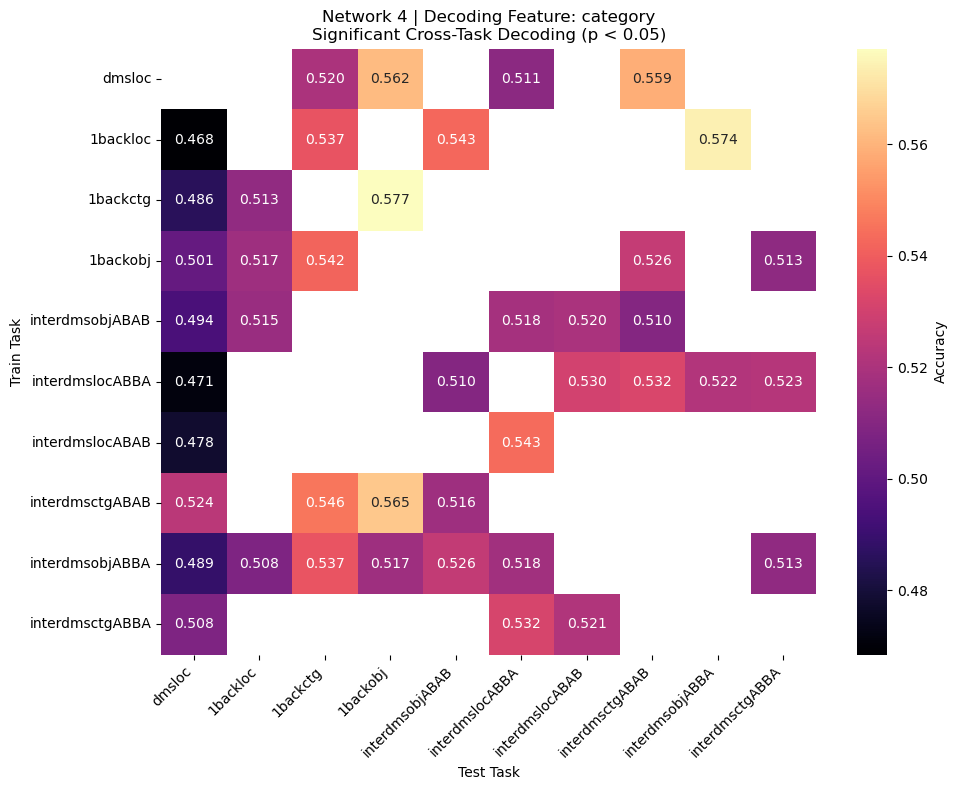

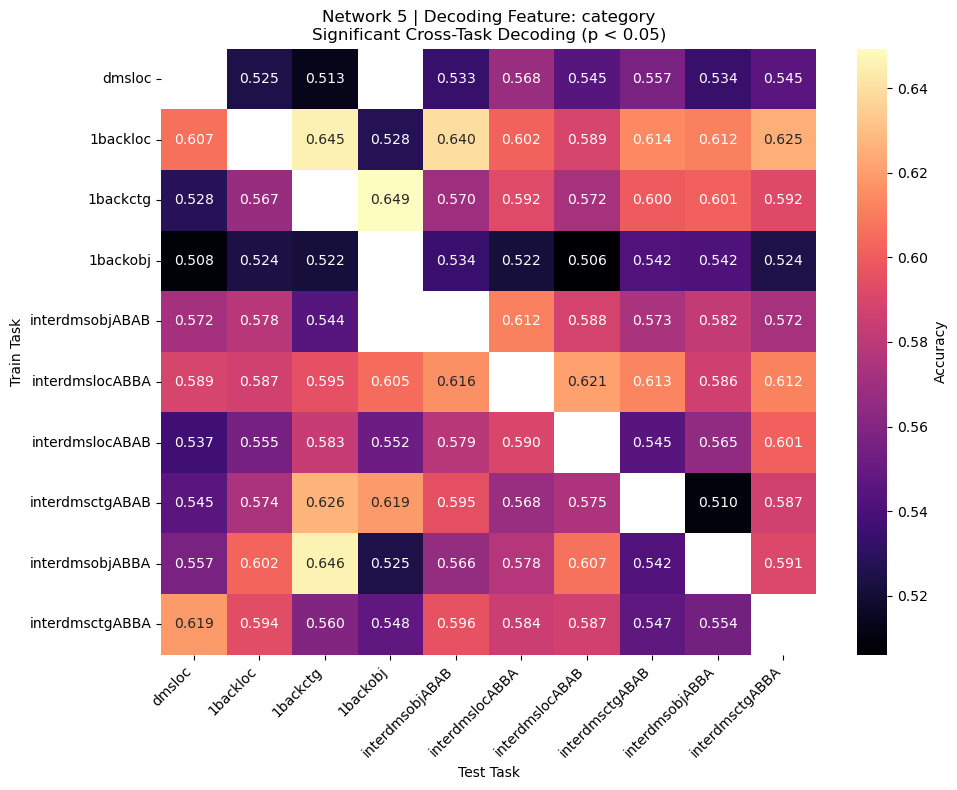

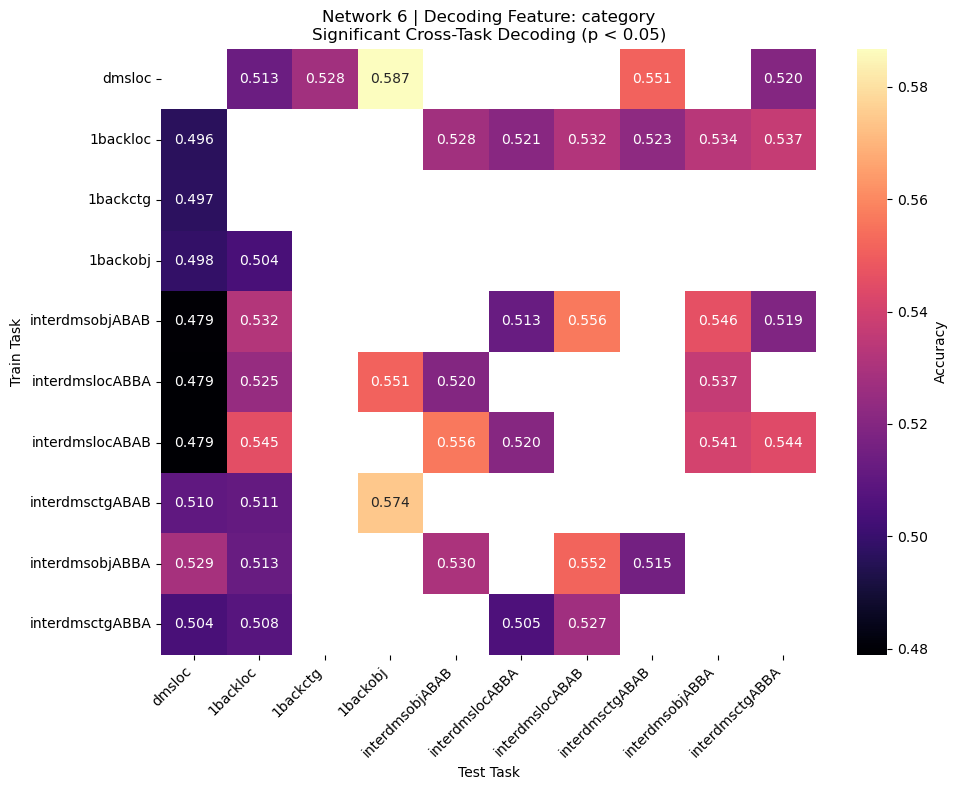

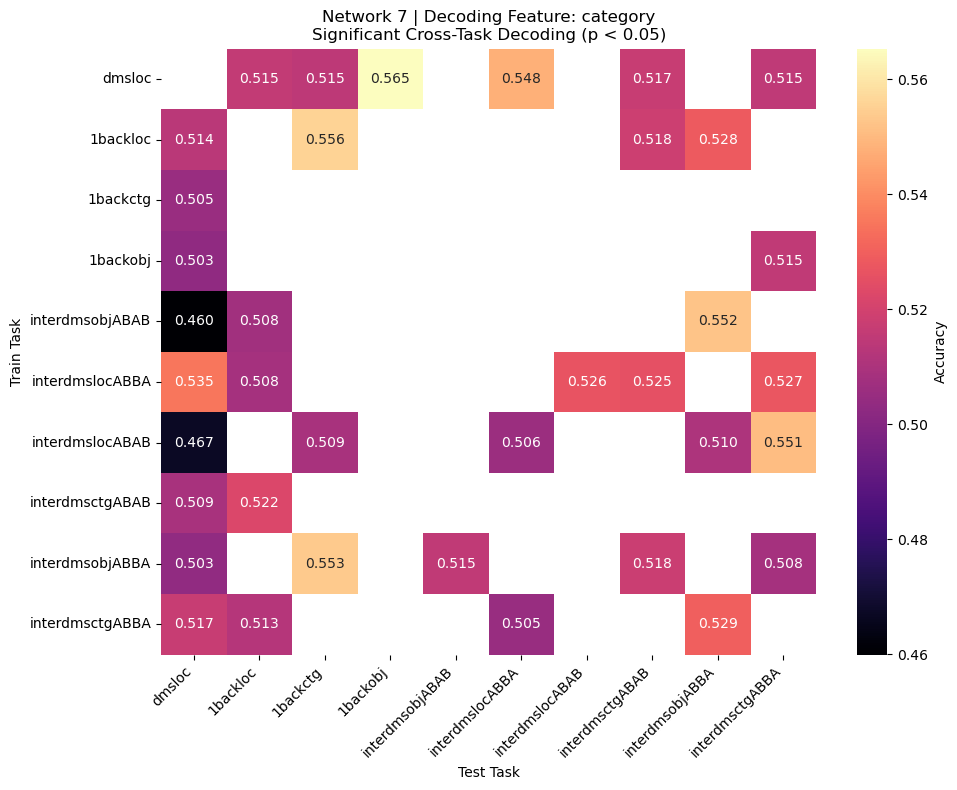

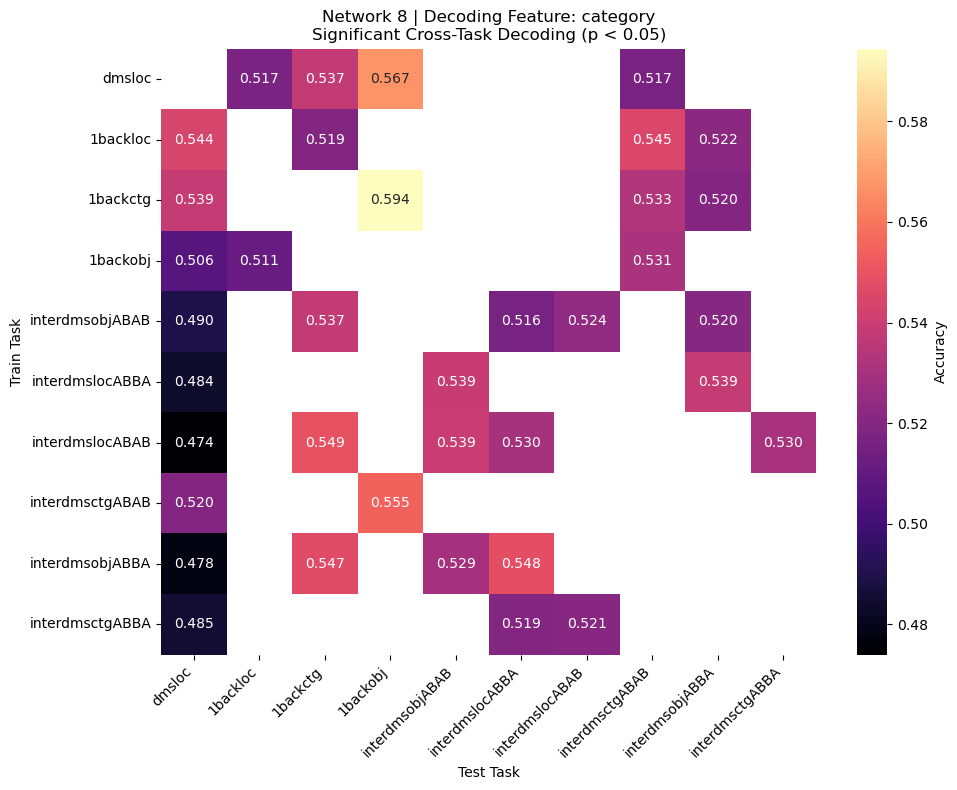

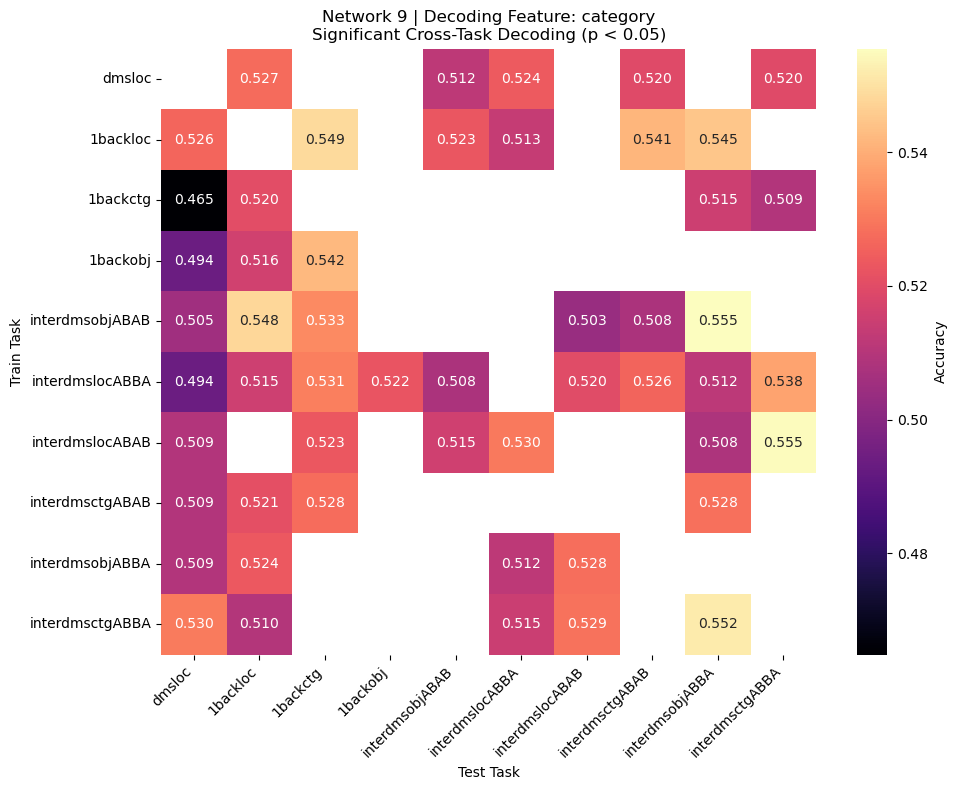

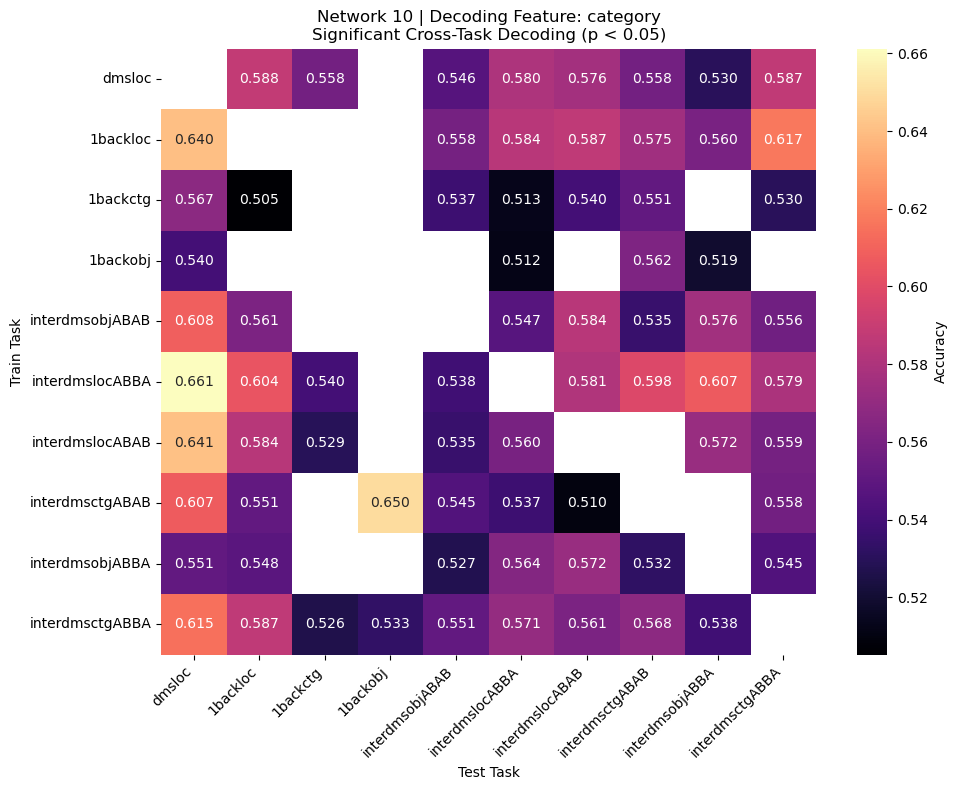

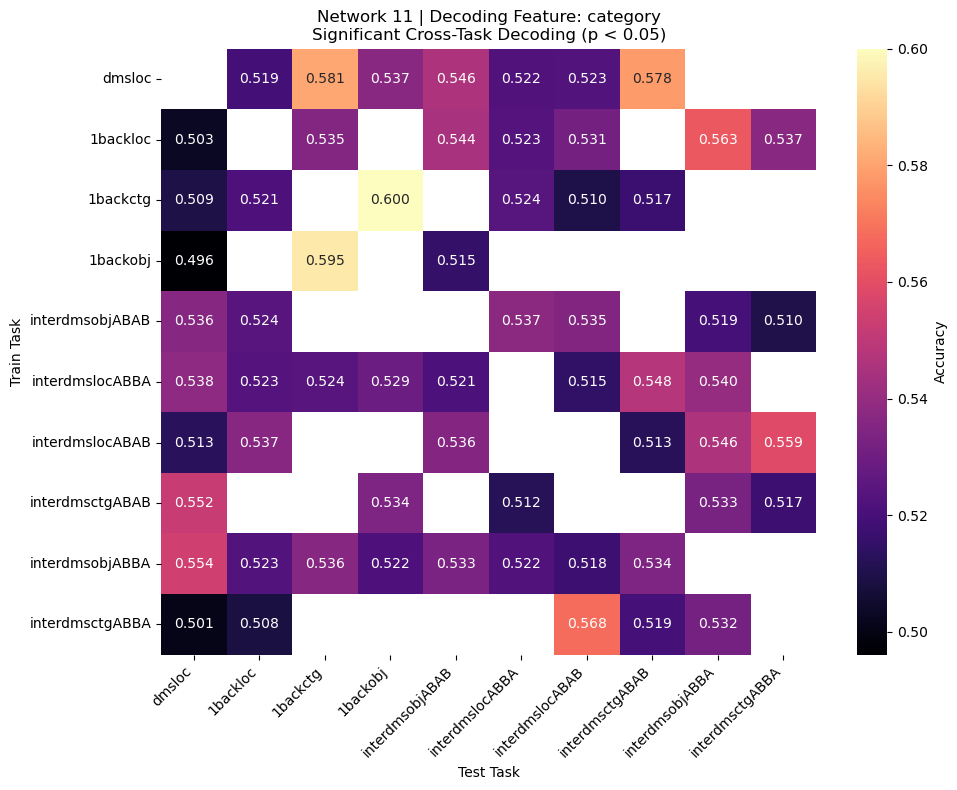

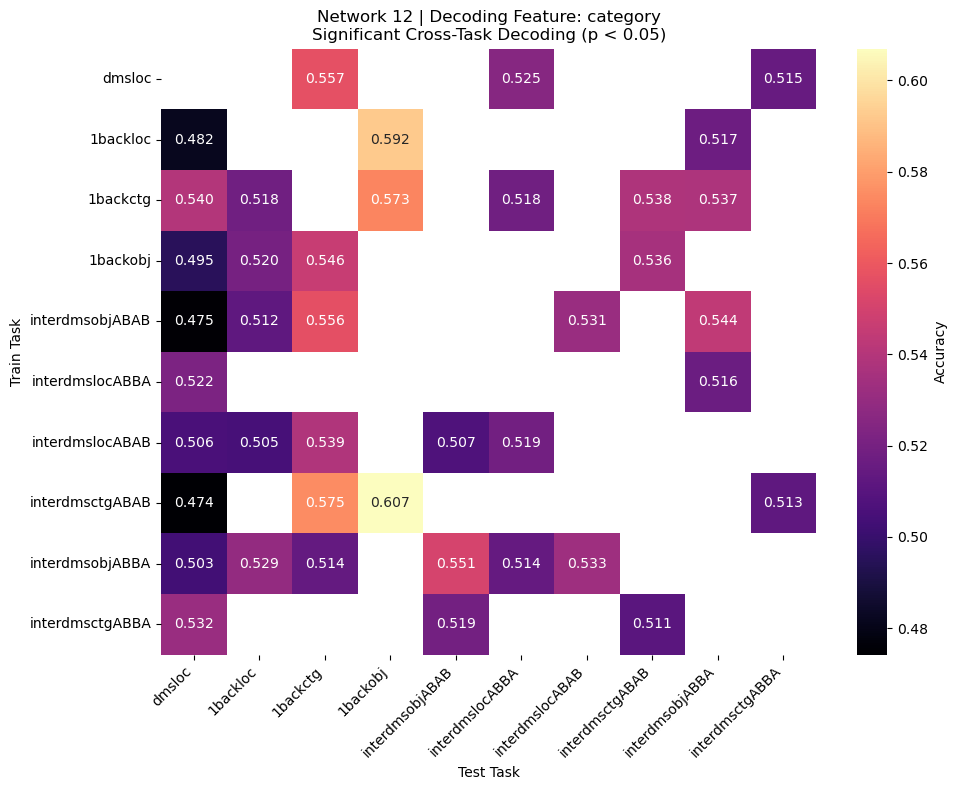

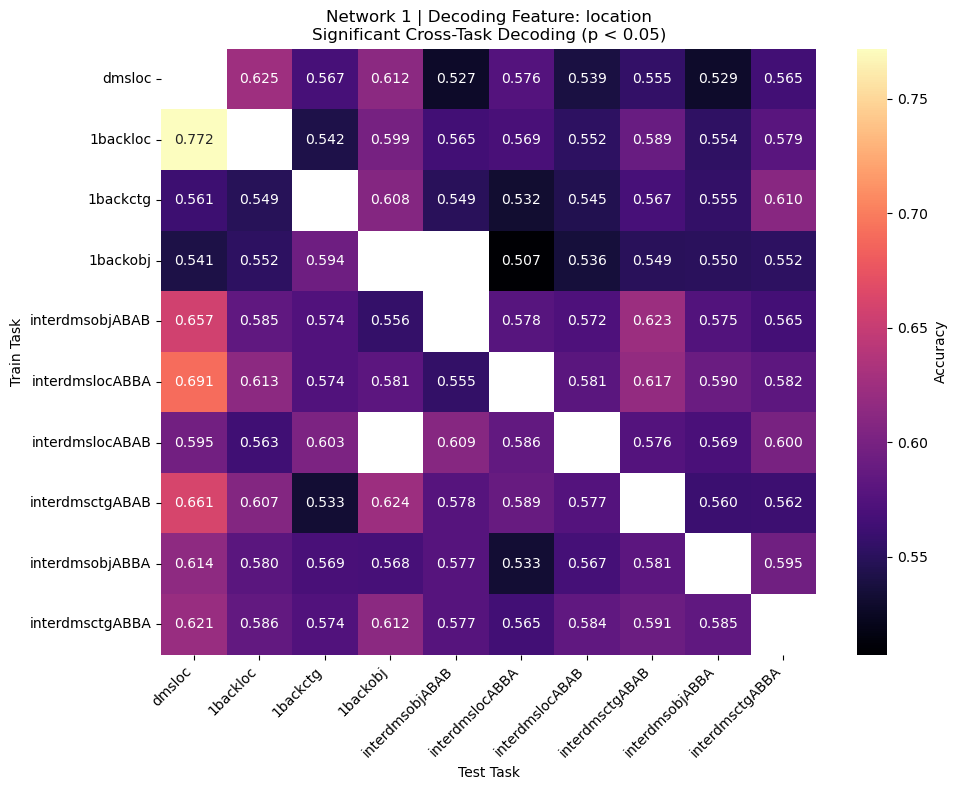

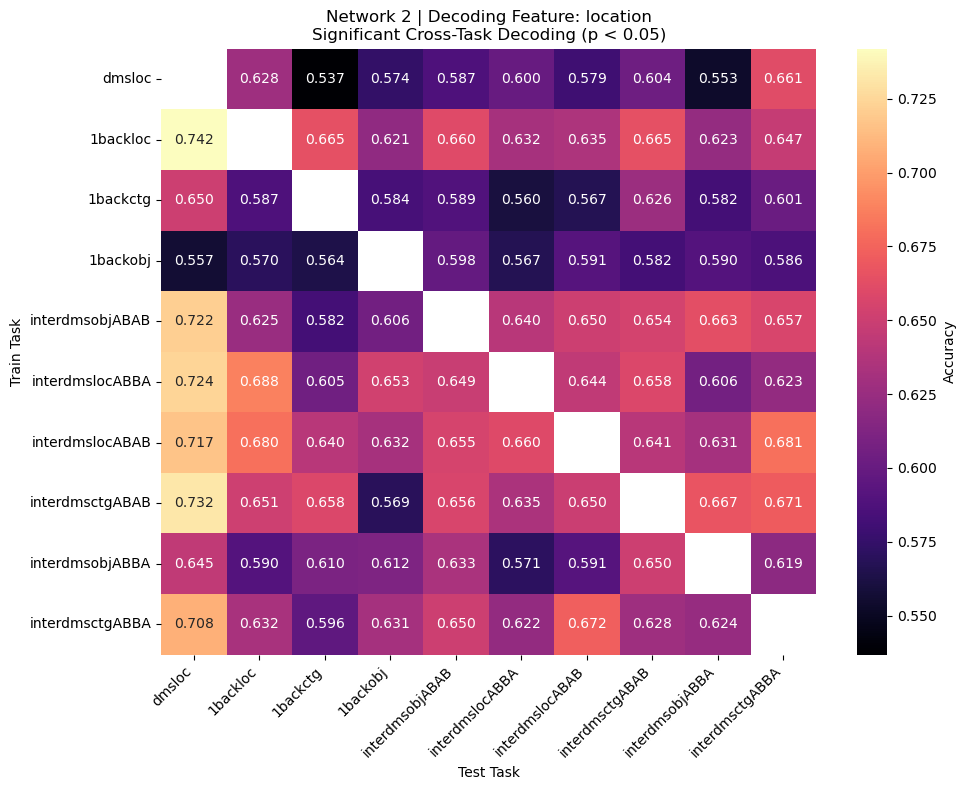

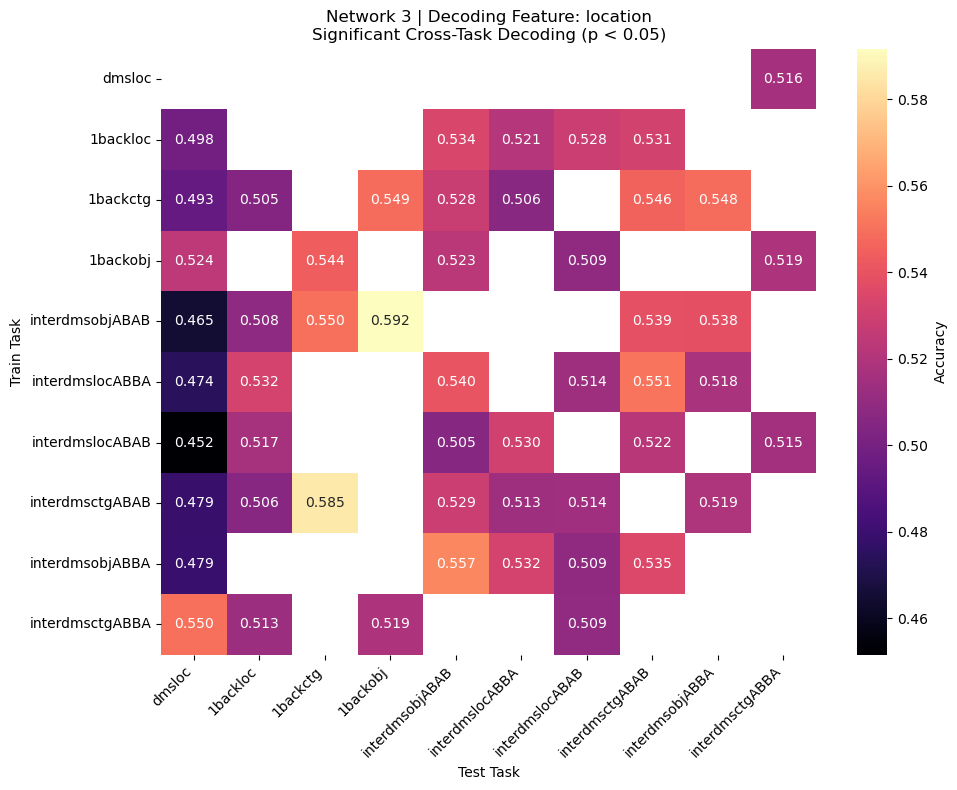

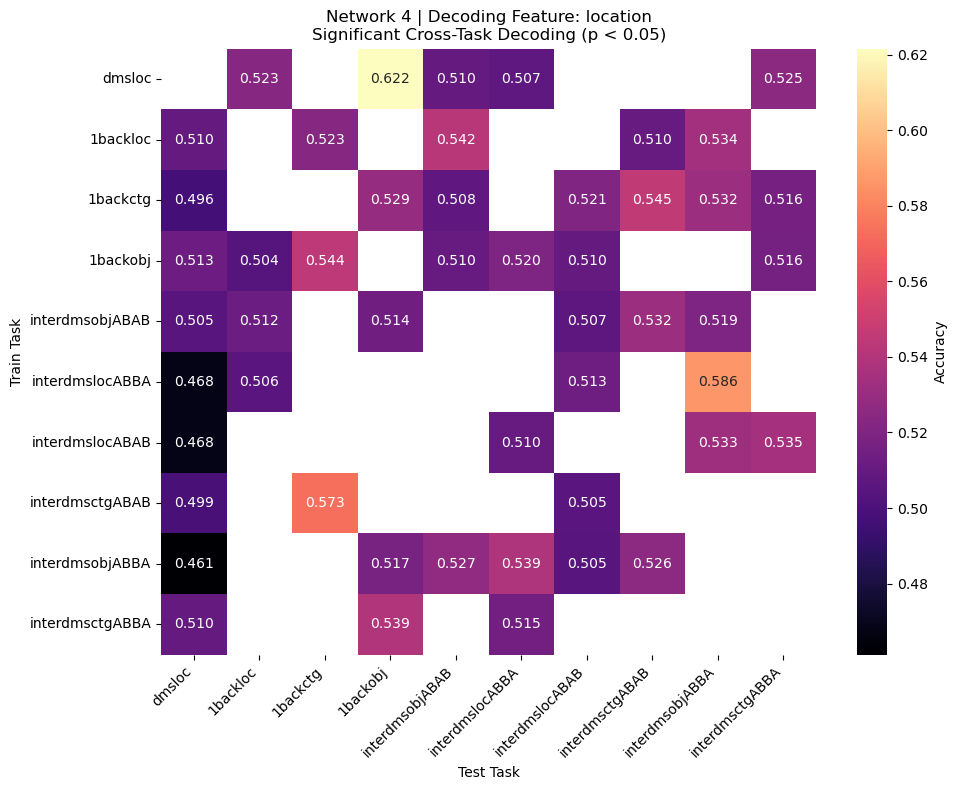

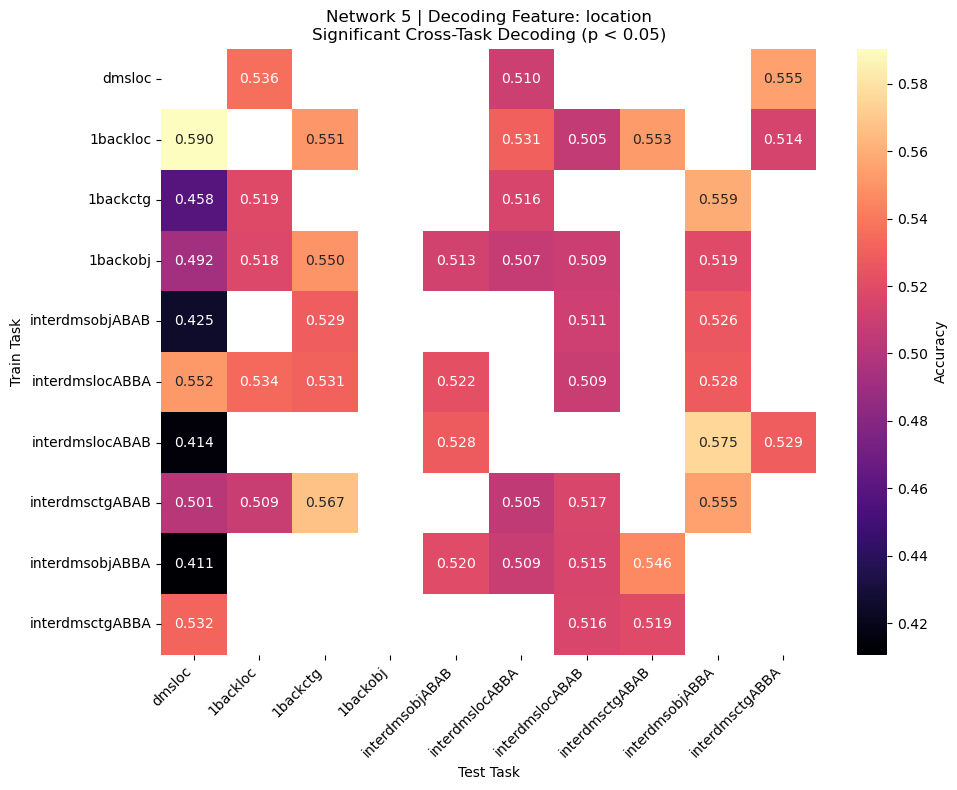

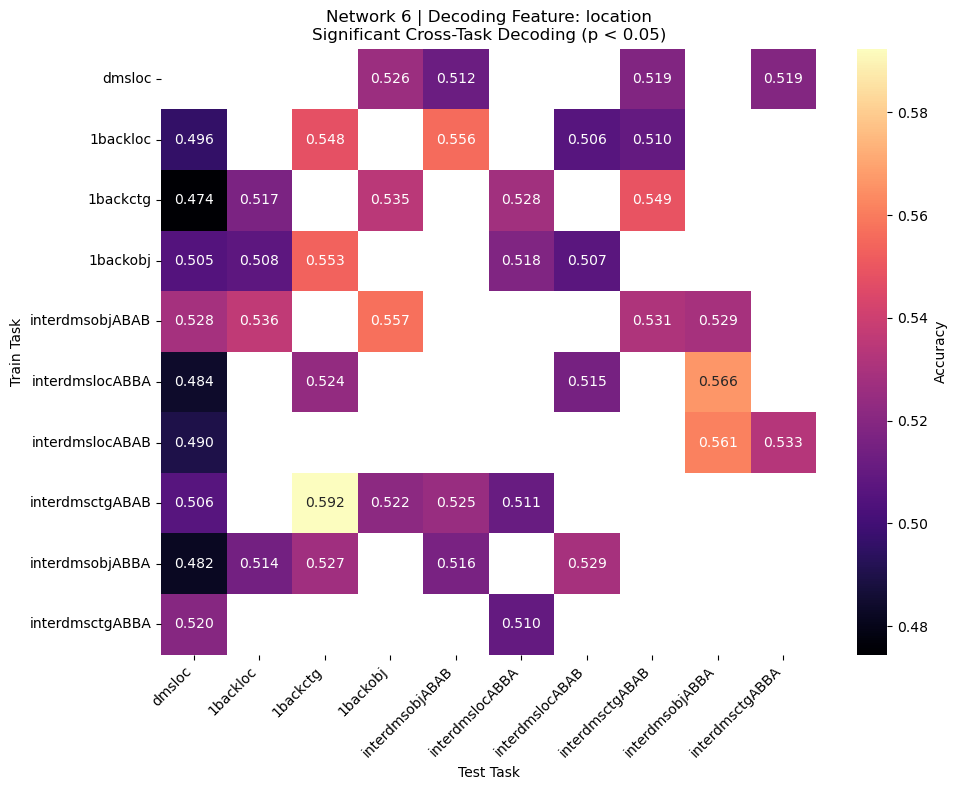

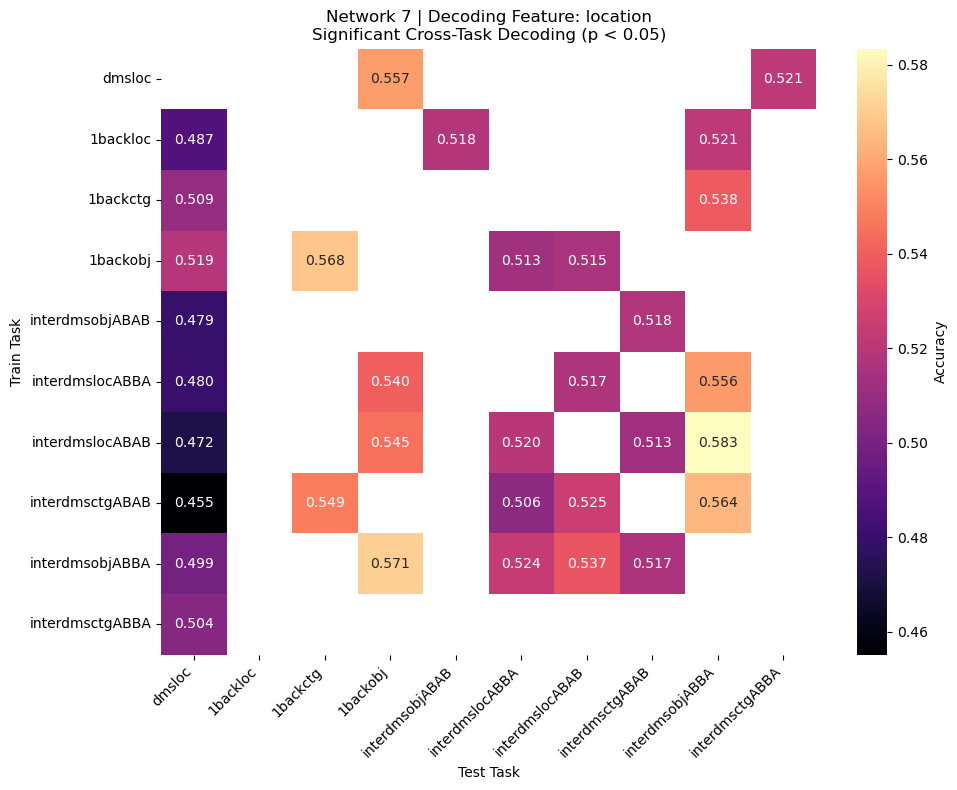

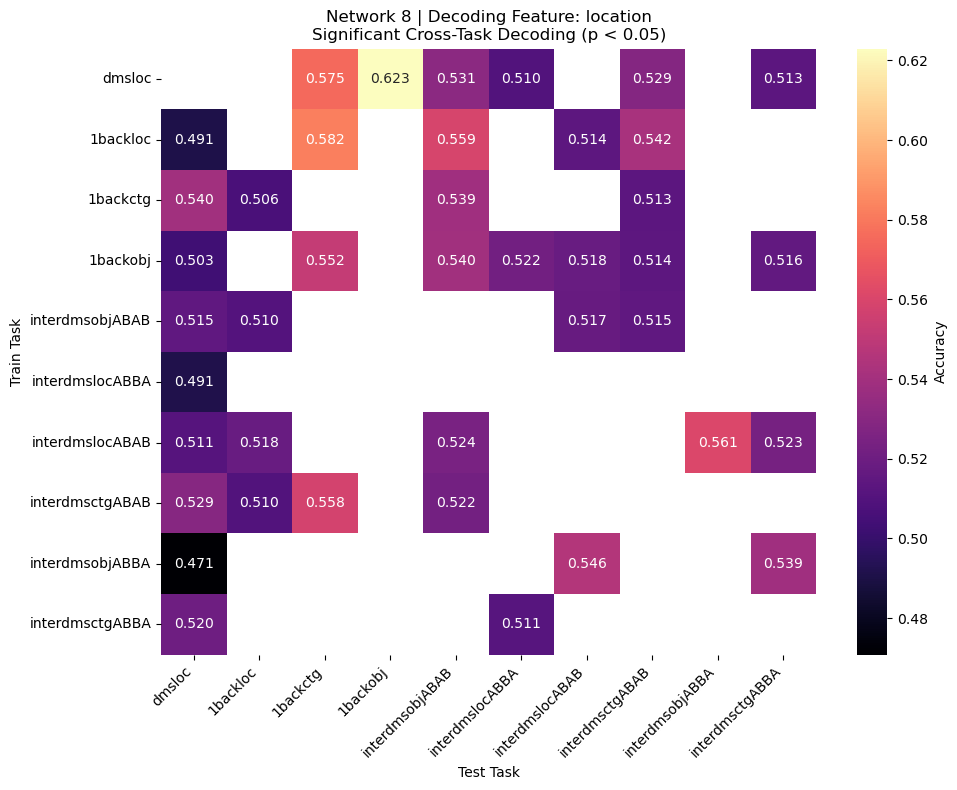

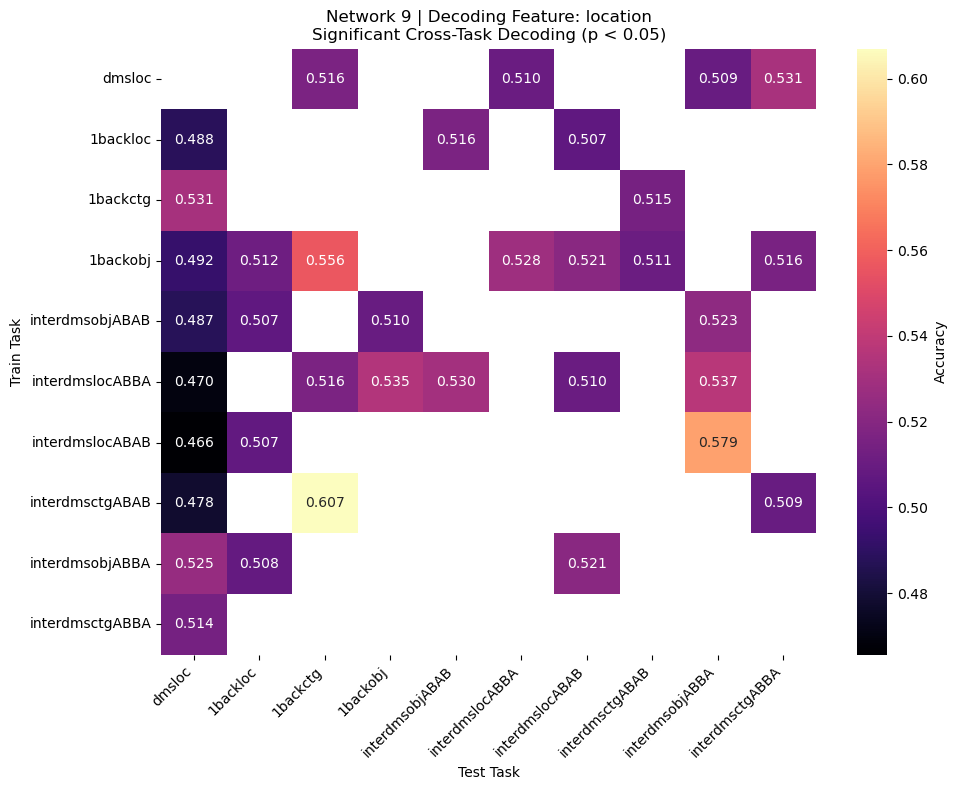

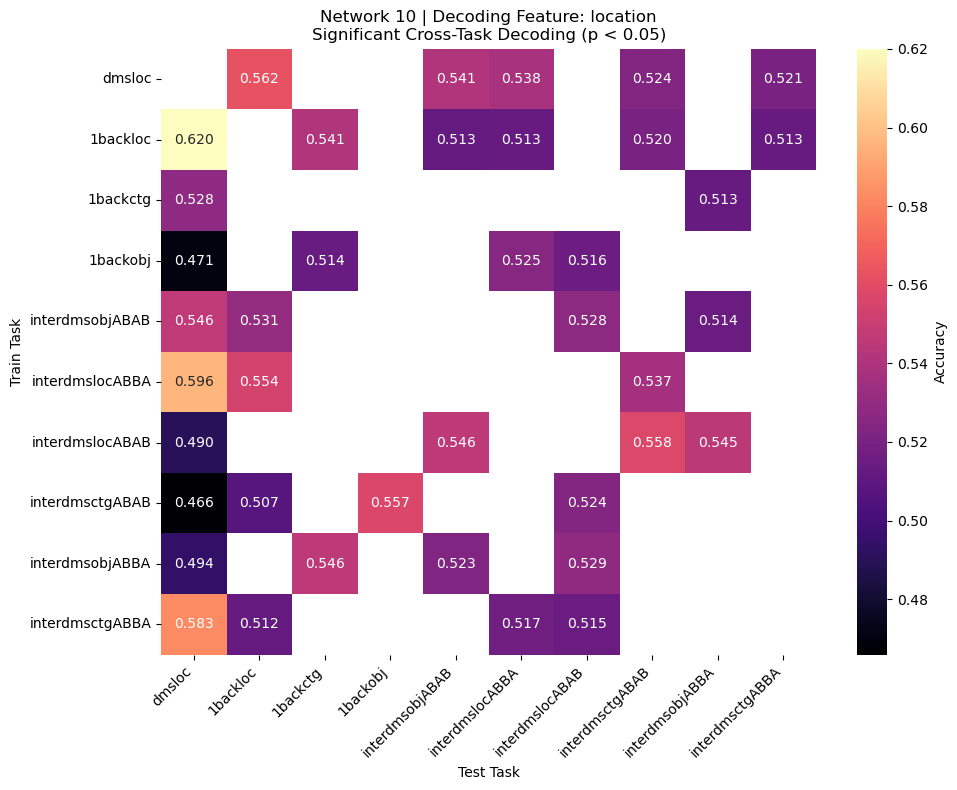

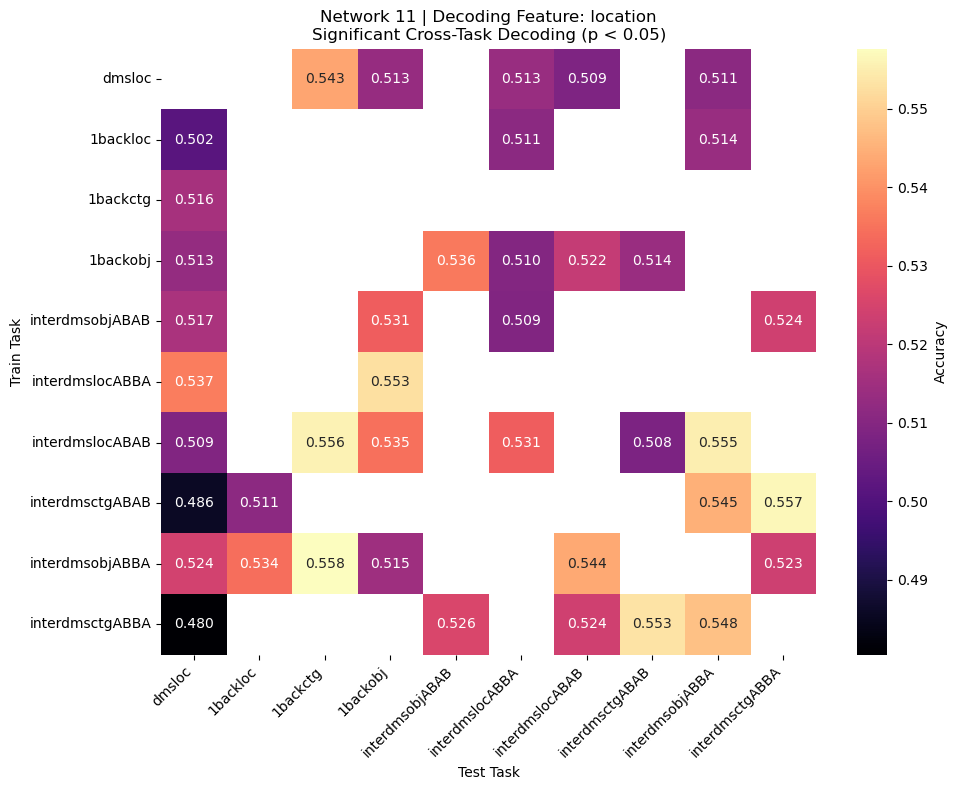

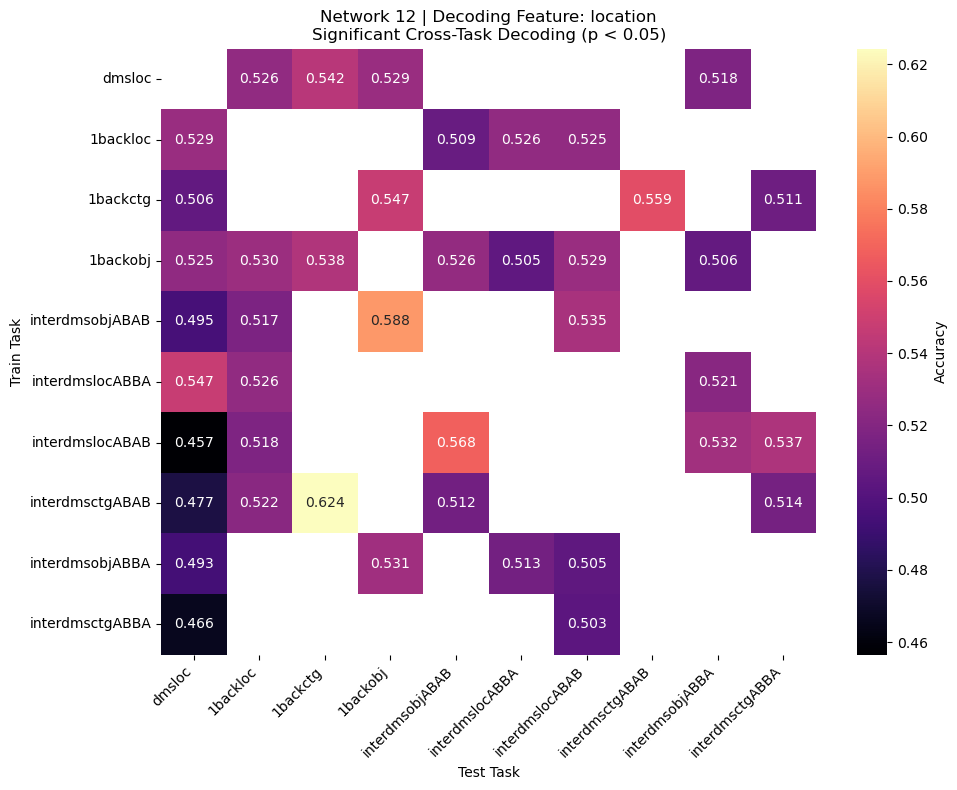

In [4]:
# === Loop over features and networks ===
for feat in decoding_features:
    for net_id in network_ids:
        acc_matrix = np.full((len(tasks), len(tasks)), np.nan)
        pval_matrix = np.full((len(tasks), len(tasks)), np.nan)
        sig_mask = np.full((len(tasks), len(tasks)), False)  # True = not significant

        for i, train_task in enumerate(tasks):
            for j, test_task in enumerate(tasks):
                if train_task == test_task:
                    continue

                accs = []
                pvals = []
                for rep in reps:
                    base_path = parent_dir / f"network_level_results_cross_task/{train_task}_to_{test_task}_{feat}"
                    acc_path = base_path / f"regionwise_acc_rep{rep}.npy"
                    pval_path = base_path / f"p_values_map_corrected_rep{rep}.npy"

                    if not acc_path.exists() or not pval_path.exists():
                        continue

                    acc_map = np.load(acc_path).squeeze()
                    pval_map = np.load(pval_path).squeeze()
                    region_idx = np.where(network_voxelwise_assignment == net_id)[0]

                    if len(region_idx) > 0:
                        accs.append(acc_map[region_idx].mean())
                        pvals.append(pval_map[region_idx].mean())

                if accs and pvals:
                    acc_matrix[i, j] = np.mean(accs)
                    pval_matrix[i, j] = np.mean(pvals)
                    sig_mask[i, j] = pval_matrix[i, j] >= 0.05  # True if not significant

        # === Plot heatmap with significance mask ===
        plt.figure(figsize=(10, 8))
        sns.heatmap(
            acc_matrix,
            xticklabels=tasks,
            yticklabels=tasks,
            annot=True,
            fmt=".3f",
            cmap="magma",
            mask=np.isnan(acc_matrix) | sig_mask,
            cbar_kws={"label": "Accuracy"}
        )
        plt.title(f"Network {net_id} | Decoding Feature: {feat}\nSignificant Cross-Task Decoding (p < 0.05)")
        plt.xlabel("Test Task")
        plt.ylabel("Train Task")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()
